# Classification on Botnet DGA Dataset

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pennylane as qml
from pennylane import numpy as np

from datetime import datetime
import os
import pickle
import time

import qiskit
import qiskit.providers.aer.noise as noise

from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

In [2]:
#IBMQ.save_account('412323e770fb2ee81fb9b79d3effe940d0a7f72c3be198a65f580a20b38b00a607ad8c8a9b5322116fc1aee89be55463fe87e7a43da6af415bbaa95236fca521')

## Experiment Settings

In [3]:
import random as python_random
SEED = 123
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

n_qubits = 2
# dev = qml.device("default.mixed", wires=n_qubits)


#dev = qml.device('qiskit.aer', wires=n_qubits)


# Error probabilities
#prob_1 = 0.001  # 1-qubit gate
#prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
#error_1 = noise.depolarizing_error(prob_1, 1)
#error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
#noise_model = noise.NoiseModel()
#noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
#noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Create a PennyLane device
# dev = qml.device('qiskit.aer', wires=n_qubits, noise_model=noise_model)


# Build noise model from backend properties
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_16_melbourne')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

dev = qml.device('qiskit.aer', wires=n_qubits, backend='qasm_simulator', 
                 coupling_map=coupling_map, basis_gates=basis_gates, noise_model=noise_model)
#                 backend_options={"validation_threshold": 1e-6})


n_layers = 1 #6
num_data = 1000  #1803333
EPOCHS = 10000
BATCH_SIZE = 50 #2048


weight_shapes = {"weights": (n_layers, n_qubits)}

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

now = datetime.now()
results_folder = "RESULTS5-QiskitNoisy/nd1000_nq2_nl1_03-25-2021_14-05-55/"
#"RESULTS5-QiskitNoisy/nd" + str(num_data) + "_" + "nq" + str(n_qubits) + "_" + "nl" + str(n_layers) + "_" + now.strftime("%m-%d-%Y_%H-%M-%S") + "/"
print("results_folder: ",results_folder)
#os.mkdir(results_folder)

f = open(results_folder + "results.txt", "a", encoding='utf-8')
f.write(results_folder + "\n")

mpl.rcParams['savefig.dpi'] = 600

results_folder:  RESULTS5-QiskitNoisy/nd1000_nq2_nl1_03-25-2021_14-05-55/


## Example of a QNode

In [4]:
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

## Data processing and exploration

### Load csv data set

In [5]:
#raw_df = pd.read_csv("dataset/n"+str(num_data)+"_botnetdga_TRAIN.csv")
#raw_df.head()

In [6]:
#raw_df[['Entropy','REAlexa','MinREBotnets','InformationRadius','CharLength','TreeNewFeature','nGramReputation_Alexa','Class']].describe()

### Clean, split and normalize the data

In [7]:
#cleaned_df = raw_df.copy()
#cleaned_df.pop('Entropy')
#cleaned_df.pop('REAlexa')
#cleaned_df.pop('InformationRadius')

In [8]:
#train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
#train_df, val_df = train_test_split(train_df, test_size=0.2)

In [9]:
#train_labels = np.array(train_df.pop('Class'))
#val_labels = np.array(val_df.pop('Class'))
#test_labels = np.array(test_df.pop('Class'))

In [10]:
#train_features = np.array(train_df)
#val_features = np.array(val_df)
#test_features = np.array(test_df)

In [11]:
#scaler = StandardScaler()
#train_features = scaler.fit_transform(train_features)
#val_features = scaler.transform(val_features)
#test_features = scaler.transform(test_features)

In [12]:
#train_features = np.clip(train_features, -5, 5)
#val_features = np.clip(val_features, -5, 5)
#test_features = np.clip(test_features, -5, 5)

## Loads the already prepared benchmark datasets

In [13]:
test_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_test_features.csv") )
test_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_test_labels.csv") )

train_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_train_features.csv") )
train_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_train_labels.csv") )

val_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_val_features.csv") )
val_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_val_labels.csv") )

## Define the model and metrics 

In [14]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          n_qubits, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      qlayer,
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=100,
    mode='max',
    restore_best_weights=True)

In [16]:
def plot_loss(history, label, n, expId):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(results_folder + '_' + str(expId) + '_plot_loss.png', format='png')

    
def plot_metrics(history, expId):
  metrics = ['accuracy', 'loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(5,1,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.savefig(results_folder + '_' + str(expId) + '_plot_metrics.png', format='png')
    
def plot_cm(labels, predictions, expId , p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.savefig(results_folder + '_' + str(expId) + '_plot_cm.png', format='png')

  print('Legitimate Domain Name Detected (True Negatives): ', cm[0][0])
  print('Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives): ', cm[0][1])
  print('Botnet DGA Missed (False Negatives): ', cm[1][0])
  print('Botnet DGA Detected (True Positives): ', cm[1][1])
  print('Total Botnet DGAs: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

## Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [17]:
model = make_model()

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

print("initial_weights = ", initial_weights)

initial_weights =  /tmp/tmp4oymv4zv/initial_weights


# Experiments A - Hybrid Classical-Quantum DL

In [18]:
def runTheExperiments(expId, desc, model=None):
    
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(SEED)
    python_random.seed(SEED)
    tf.random.set_seed(SEED)

    start_time = time.time()
    f.write("\n\n\n#" + desc + "\n")
    
    if model is None:
        model = make_model()
        model.load_weights(initial_weights)

    history = model.fit(
        train_features,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        validation_data=(val_features, val_labels))

    #model.save(results_folder + 'model_' + str(expId))
    #with open(results_folder + 'history_' + str(expId), 'wb') as file_pi:
    #    pickle.dump(history.history, file_pi)

    train_predictions = model.predict(train_features, batch_size=BATCH_SIZE)
    test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)


    plot_loss(history, "history", 0, expId=expId)

    plot_metrics(history, expId=expId)

    baseline_results = model.evaluate(test_features, test_labels,
                                      batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
      print(name, ': ', value)
      f.write(name + ' : \t' + str(value) + "\n")
    print()
    plot_cm(test_labels, test_predictions, expId=expId)

    plot_roc("Train", train_labels, train_predictions, color=colors[0])
    plot_roc("Test", test_labels, test_predictions, color=colors[0], linestyle='--')
    plt.legend(loc='lower right')
    plt.savefig(results_folder + '_' + str(expId) + '_plot_roc.png', format='png')
    
    f.write("--- %s seconds ---" % (time.time() - start_time))  
    f.write("\n\n")
    f.write(qnode.draw())
    f.flush()
    
    tf.keras.utils.plot_model(
    model, to_file=results_folder+'model'+ str(expId) + '.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=600
    )
        
    return model, history
    

## AngleEmbedding

Epoch 1/10000
13/13 [==============================] - 1229s 95s/step - loss: 0.7207 - tp: 100.7143 - fp: 119.0000 - tn: 71.5000 - fn: 78.6429 - accuracy: 0.4520 - precision: 0.4438 - recall: 0.5548 - auc: 0.4962 - val_loss: 0.7743 - val_tp: 20.0000 - val_fp: 41.0000 - val_tn: 32.0000 - val_fn: 66.0000 - val_accuracy: 0.3270 - val_precision: 0.3279 - val_recall: 0.2326 - val_auc: 0.2357
Epoch 2/10000
13/13 [==============================] - 1224s 94s/step - loss: 0.7301 - tp: 80.5714 - fp: 90.5000 - tn: 101.4286 - fn: 97.3571 - accuracy: 0.4964 - precision: 0.4671 - recall: 0.4605 - auc: 0.4767 - val_loss: 0.7663 - val_tp: 19.0000 - val_fp: 25.0000 - val_tn: 48.0000 - val_fn: 67.0000 - val_accuracy: 0.4214 - val_precision: 0.4318 - val_recall: 0.2209 - val_auc: 0.2691
Epoch 3/10000
13/13 [==============================] - 1237s 95s/step - loss: 0.7398 - tp: 60.0000 - fp: 90.6429 - tn: 103.1429 - fn: 116.0714 - accuracy: 0.4298 - precision: 0.3813 - recall: 0.3528 - auc: 0.3965 - val_lo

13/13 [==============================] - 1234s 95s/step - loss: 0.6352 - tp: 57.7143 - fp: 5.3571 - tn: 186.4286 - fn: 120.3571 - accuracy: 0.6490 - precision: 0.9280 - recall: 0.2912 - auc: 0.7070 - val_loss: 0.6377 - val_tp: 38.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 48.0000 - val_accuracy: 0.6792 - val_precision: 0.9268 - val_recall: 0.4419 - val_auc: 0.8346
Epoch 44/10000
13/13 [==============================] - 1234s 95s/step - loss: 0.6096 - tp: 67.3571 - fp: 8.5714 - tn: 184.7143 - fn: 109.2143 - accuracy: 0.6950 - precision: 0.8793 - recall: 0.4049 - auc: 0.7486 - val_loss: 0.6356 - val_tp: 40.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 46.0000 - val_accuracy: 0.6918 - val_precision: 0.9302 - val_recall: 0.4651 - val_auc: 0.8360
Epoch 45/10000
13/13 [==============================] - 1234s 95s/step - loss: 0.6378 - tp: 67.0000 - fp: 10.9286 - tn: 180.3571 - fn: 111.5714 - accuracy: 0.6638 - precision: 0.8526 - recall: 0.3715 - auc: 0.6599 - val_loss: 0.6356 - va

13/13 [==============================] - 1236s 95s/step - loss: 0.5805 - tp: 77.8571 - fp: 9.5000 - tn: 184.1429 - fn: 98.3571 - accuracy: 0.7088 - precision: 0.8976 - recall: 0.4303 - auc: 0.7577 - val_loss: 0.5830 - val_tp: 58.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 28.0000 - val_accuracy: 0.7987 - val_precision: 0.9355 - val_recall: 0.6744 - val_auc: 0.8574
Epoch 86/10000
13/13 [==============================] - 1237s 95s/step - loss: 0.5733 - tp: 87.7857 - fp: 9.9286 - tn: 176.0000 - fn: 96.1429 - accuracy: 0.7074 - precision: 0.8947 - recall: 0.4750 - auc: 0.7602 - val_loss: 0.5811 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.8540
Epoch 87/10000
13/13 [==============================] - 1237s 95s/step - loss: 0.5921 - tp: 77.5000 - fp: 9.7857 - tn: 179.8571 - fn: 102.7143 - accuracy: 0.6989 - precision: 0.8835 - recall: 0.4436 - auc: 0.7192 - val_loss: 0.5797 - val_t

13/13 [==============================] - 1179s 91s/step - loss: 0.5688 - tp: 88.5000 - fp: 11.3571 - tn: 175.3571 - fn: 94.6429 - accuracy: 0.7200 - precision: 0.8960 - recall: 0.5040 - auc: 0.7321 - val_loss: 0.5526 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.8661
Epoch 128/10000
13/13 [==============================] - 1179s 91s/step - loss: 0.5689 - tp: 88.0714 - fp: 10.4286 - tn: 179.8571 - fn: 91.5000 - accuracy: 0.7204 - precision: 0.8929 - recall: 0.4913 - auc: 0.7416 - val_loss: 0.5530 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.8498
Epoch 129/10000
13/13 [==============================] - 1179s 91s/step - loss: 0.5696 - tp: 91.4286 - fp: 8.9286 - tn: 175.5714 - fn: 93.9286 - accuracy: 0.7202 - precision: 0.9233 - recall: 0.4977 - auc: 0.7519 - val_loss: 0.5522 - va

13/13 [==============================] - 1179s 91s/step - loss: 0.5501 - tp: 91.3571 - fp: 9.0714 - tn: 181.9286 - fn: 87.5000 - accuracy: 0.7343 - precision: 0.9254 - recall: 0.4993 - auc: 0.7701 - val_loss: 0.5374 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.8876
Epoch 170/10000
13/13 [==============================] - 1178s 91s/step - loss: 0.5415 - tp: 95.4286 - fp: 9.7143 - tn: 184.6429 - fn: 80.0714 - accuracy: 0.7555 - precision: 0.8945 - recall: 0.5396 - auc: 0.7588 - val_loss: 0.5401 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.8809
Epoch 171/10000
13/13 [==============================] - 1176s 91s/step - loss: 0.5185 - tp: 94.6429 - fp: 8.0714 - tn: 186.4286 - fn: 80.7143 - accuracy: 0.7701 - precision: 0.9232 - recall: 0.5597 - auc: 0.7946 - val_loss: 0.5366 - val_

13/13 [==============================] - 1178s 91s/step - loss: 0.5139 - tp: 100.1429 - fp: 3.7857 - tn: 187.3571 - fn: 78.5714 - accuracy: 0.7699 - precision: 0.9713 - recall: 0.5399 - auc: 0.7825 - val_loss: 0.5208 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9118
Epoch 212/10000
13/13 [==============================] - 1176s 91s/step - loss: 0.5386 - tp: 94.0000 - fp: 12.5714 - tn: 180.8571 - fn: 82.4286 - accuracy: 0.7497 - precision: 0.8937 - recall: 0.5430 - auc: 0.7572 - val_loss: 0.5258 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9055
Epoch 213/10000
13/13 [==============================] - 1179s 91s/step - loss: 0.5293 - tp: 104.8571 - fp: 11.2143 - tn: 180.0714 - fn: 73.7143 - accuracy: 0.7664 - precision: 0.8979 - recall: 0.5763 - auc: 0.7531 - val_loss: 0.5226 - 

13/13 [==============================] - 1180s 91s/step - loss: 0.5086 - tp: 95.9286 - fp: 10.1429 - tn: 187.0714 - fn: 76.7143 - accuracy: 0.7768 - precision: 0.9122 - recall: 0.5722 - auc: 0.7817 - val_loss: 0.5209 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9068
Epoch 233/10000
13/13 [==============================] - 1179s 91s/step - loss: 0.5496 - tp: 92.1429 - fp: 12.2143 - tn: 179.4286 - fn: 86.0714 - accuracy: 0.7329 - precision: 0.8765 - recall: 0.5090 - auc: 0.7451 - val_loss: 0.5169 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9136
Epoch 234/10000
13/13 [==============================] - 1184s 91s/step - loss: 0.5216 - tp: 103.5000 - fp: 7.7143 - tn: 185.7857 - fn: 72.8571 - accuracy: 0.7859 - precision: 0.9247 - recall: 0.5854 - auc: 0.7842 - val_loss: 0.5188 - v

13/13 [==============================] - 1179s 91s/step - loss: 0.4782 - tp: 100.0714 - fp: 9.6429 - tn: 189.0714 - fn: 71.0714 - accuracy: 0.7998 - precision: 0.8986 - recall: 0.6204 - auc: 0.8064 - val_loss: 0.5146 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9233
Epoch 275/10000
13/13 [==============================] - 1179s 91s/step - loss: 0.4892 - tp: 110.3571 - fp: 8.7857 - tn: 182.2857 - fn: 68.4286 - accuracy: 0.7975 - precision: 0.9268 - recall: 0.6323 - auc: 0.7845 - val_loss: 0.5098 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9357
Epoch 276/10000
13/13 [==============================] - 1181s 91s/step - loss: 0.5192 - tp: 107.7143 - fp: 8.1429 - tn: 181.0714 - fn: 72.9286 - accuracy: 0.7705 - precision: 0.9206 - recall: 0.5837 - auc: 0.7642 - val_loss: 0.5100 - v

13/13 [==============================] - 1179s 91s/step - loss: 0.4937 - tp: 109.9286 - fp: 7.9286 - tn: 182.5000 - fn: 69.5000 - accuracy: 0.7804 - precision: 0.9282 - recall: 0.6044 - auc: 0.7999 - val_loss: 0.4985 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9373
Epoch 317/10000
13/13 [==============================] - 1180s 91s/step - loss: 0.4639 - tp: 111.0000 - fp: 1.8571 - tn: 191.9286 - fn: 65.0714 - accuracy: 0.8290 - precision: 0.9886 - recall: 0.6432 - auc: 0.8260 - val_loss: 0.4998 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9364
Epoch 318/10000
13/13 [==============================] - 1182s 91s/step - loss: 0.4896 - tp: 106.0714 - fp: 6.3571 - tn: 188.3571 - fn: 69.0714 - accuracy: 0.7952 - precision: 0.9492 - recall: 0.6037 - auc: 0.8226 - val_loss: 0.5015 - v

13/13 [==============================] - 1183s 91s/step - loss: 0.4944 - tp: 101.0714 - fp: 7.7857 - tn: 183.2857 - fn: 77.7143 - accuracy: 0.7739 - precision: 0.9375 - recall: 0.5701 - auc: 0.7670 - val_loss: 0.4925 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9442
Epoch 359/10000
13/13 [==============================] - 1180s 91s/step - loss: 0.4793 - tp: 111.7857 - fp: 6.8571 - tn: 180.6429 - fn: 70.5714 - accuracy: 0.7890 - precision: 0.9409 - recall: 0.6119 - auc: 0.8072 - val_loss: 0.4898 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9419
Epoch 360/10000
13/13 [==============================] - 1184s 91s/step - loss: 0.5299 - tp: 101.2143 - fp: 11.2143 - tn: 177.7857 - fn: 79.6429 - accuracy: 0.7512 - precision: 0.8988 - recall: 0.5544 - auc: 0.7354 - val_loss: 0.4918 - 

13/13 [==============================] - 1179s 91s/step - loss: 0.4830 - tp: 109.9286 - fp: 4.9286 - tn: 187.2143 - fn: 67.7857 - accuracy: 0.8038 - precision: 0.9600 - recall: 0.6222 - auc: 0.7657 - val_loss: 0.4945 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9392
Epoch 380/10000
13/13 [==============================] - 1180s 91s/step - loss: 0.5066 - tp: 98.9286 - fp: 8.7857 - tn: 185.7857 - fn: 76.3571 - accuracy: 0.7665 - precision: 0.9045 - recall: 0.5630 - auc: 0.7876 - val_loss: 0.4905 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9365
Epoch 381/10000
13/13 [==============================] - 1178s 91s/step - loss: 0.4589 - tp: 111.3571 - fp: 5.5714 - tn: 188.5714 - fn: 64.3571 - accuracy: 0.8116 - precision: 0.9508 - recall: 0.6396 - auc: 0.8230 - val_loss: 0.4929 - va

13/13 [==============================] - 1179s 91s/step - loss: 0.4698 - tp: 107.7857 - fp: 5.3571 - tn: 189.5000 - fn: 67.2143 - accuracy: 0.8085 - precision: 0.9523 - recall: 0.6198 - auc: 0.8016 - val_loss: 0.4885 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9412
Epoch 422/10000
13/13 [==============================] - 1179s 91s/step - loss: 0.4866 - tp: 109.7143 - fp: 8.5714 - tn: 183.4286 - fn: 68.1429 - accuracy: 0.7855 - precision: 0.9062 - recall: 0.6079 - auc: 0.8083 - val_loss: 0.4847 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9428
Epoch 423/10000
13/13 [==============================] - 1182s 91s/step - loss: 0.5304 - tp: 101.0000 - fp: 5.9286 - tn: 177.7143 - fn: 85.2143 - accuracy: 0.7393 - precision: 0.9388 - recall: 0.5339 - auc: 0.7762 - val_loss: 0.4862 - v

13/13 [==============================] - 1117s 86s/step - loss: 0.4822 - tp: 98.5714 - fp: 4.0000 - tn: 188.2857 - fn: 79.0000 - accuracy: 0.7816 - precision: 0.9661 - recall: 0.5657 - auc: 0.8090 - val_loss: 0.4776 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9452
Epoch 464/10000
13/13 [==============================] - 1117s 86s/step - loss: 0.4832 - tp: 105.7857 - fp: 7.7857 - tn: 180.7857 - fn: 75.5000 - accuracy: 0.7774 - precision: 0.9306 - recall: 0.5905 - auc: 0.7931 - val_loss: 0.4736 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9439
Epoch 465/10000
13/13 [==============================] - 1117s 86s/step - loss: 0.4438 - tp: 115.5000 - fp: 7.4286 - tn: 186.1429 - fn: 60.7857 - accuracy: 0.8199 - precision: 0.9381 - recall: 0.6594 - auc: 0.8353 - val_loss: 0.4774 - va

13/13 [==============================] - 1120s 86s/step - loss: 0.4957 - tp: 111.2857 - fp: 4.7857 - tn: 178.8571 - fn: 74.9286 - accuracy: 0.7707 - precision: 0.9543 - recall: 0.5898 - auc: 0.7868 - val_loss: 0.4769 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9458
Epoch 506/10000
13/13 [==============================] - 1116s 86s/step - loss: 0.4693 - tp: 112.1429 - fp: 4.8571 - tn: 185.4286 - fn: 67.4286 - accuracy: 0.8022 - precision: 0.9557 - recall: 0.6091 - auc: 0.7981 - val_loss: 0.4755 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9491
Epoch 507/10000
13/13 [==============================] - 1118s 86s/step - loss: 0.4765 - tp: 108.5000 - fp: 7.7143 - tn: 185.7857 - fn: 67.8571 - accuracy: 0.7966 - precision: 0.9324 - recall: 0.6092 - auc: 0.7919 - val_loss: 0.4756 - v

13/13 [==============================] - 1118s 86s/step - loss: 0.4613 - tp: 118.7143 - fp: 10.0000 - tn: 180.5000 - fn: 60.6429 - accuracy: 0.8048 - precision: 0.9168 - recall: 0.6630 - auc: 0.8212 - val_loss: 0.4673 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9499
Epoch 548/10000
13/13 [==============================] - 1113s 86s/step - loss: 0.4489 - tp: 110.6429 - fp: 7.4286 - tn: 186.8571 - fn: 64.9286 - accuracy: 0.8166 - precision: 0.9411 - recall: 0.6518 - auc: 0.8067 - val_loss: 0.4686 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9501
Epoch 549/10000
13/13 [==============================] - 1115s 86s/step - loss: 0.4930 - tp: 109.0000 - fp: 7.7143 - tn: 180.0714 - fn: 73.0714 - accuracy: 0.7750 - precision: 0.9336 - recall: 0.5800 - auc: 0.7510 - val_loss: 0.4721 - 

13/13 [==============================] - 1116s 86s/step - loss: 0.4606 - tp: 110.5000 - fp: 4.4286 - tn: 190.3571 - fn: 64.5714 - accuracy: 0.8126 - precision: 0.9679 - recall: 0.6112 - auc: 0.7940 - val_loss: 0.4592 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9536
Epoch 590/10000
13/13 [==============================] - 1116s 86s/step - loss: 0.4799 - tp: 111.7143 - fp: 7.7857 - tn: 178.6429 - fn: 71.7143 - accuracy: 0.7915 - precision: 0.9408 - recall: 0.6203 - auc: 0.8043 - val_loss: 0.4606 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9519
Epoch 591/10000
13/13 [==============================] - 1114s 86s/step - loss: 0.4419 - tp: 110.7143 - fp: 3.2143 - tn: 191.3571 - fn: 64.5714 - accuracy: 0.8235 - precision: 0.9803 - recall: 0.6400 - auc: 0.8118 - val_loss: 0.4580 - v

13/13 [==============================] - 1117s 86s/step - loss: 0.5013 - tp: 105.3571 - fp: 8.0000 - tn: 184.2857 - fn: 72.2143 - accuracy: 0.7823 - precision: 0.9255 - recall: 0.5893 - auc: 0.7480 - val_loss: 0.4551 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9525
Epoch 632/10000
13/13 [==============================] - 1115s 86s/step - loss: 0.4714 - tp: 104.7857 - fp: 4.4286 - tn: 189.2857 - fn: 71.3571 - accuracy: 0.7981 - precision: 0.9619 - recall: 0.5942 - auc: 0.7789 - val_loss: 0.4561 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9514
Epoch 633/10000
13/13 [==============================] - 1114s 86s/step - loss: 0.4362 - tp: 121.2857 - fp: 4.9286 - tn: 185.2143 - fn: 58.4286 - accuracy: 0.8314 - precision: 0.9679 - recall: 0.6837 - auc: 0.8214 - val_loss: 0.4562 - v

13/13 [==============================] - 1113s 86s/step - loss: 0.4969 - tp: 107.0714 - fp: 6.5000 - tn: 177.7857 - fn: 78.5000 - accuracy: 0.7645 - precision: 0.9494 - recall: 0.5757 - auc: 0.7886 - val_loss: 0.4602 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9513
Epoch 674/10000
13/13 [==============================] - 1116s 86s/step - loss: 0.4400 - tp: 114.9286 - fp: 6.5000 - tn: 187.5714 - fn: 60.8571 - accuracy: 0.8243 - precision: 0.9541 - recall: 0.6557 - auc: 0.8006 - val_loss: 0.4613 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9534
Epoch 675/10000
13/13 [==============================] - 1114s 86s/step - loss: 0.4373 - tp: 111.5000 - fp: 7.2143 - tn: 191.7857 - fn: 59.3571 - accuracy: 0.8300 - precision: 0.9403 - recall: 0.6659 - auc: 0.8102 - val_loss: 0.4606 - v

13/13 [==============================] - 1119s 86s/step - loss: 0.4279 - tp: 119.3571 - fp: 6.6429 - tn: 184.4286 - fn: 59.4286 - accuracy: 0.8308 - precision: 0.9590 - recall: 0.6808 - auc: 0.8189 - val_loss: 0.4579 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9498
Epoch 716/10000
13/13 [==============================] - 1117s 86s/step - loss: 0.4492 - tp: 115.8571 - fp: 10.0000 - tn: 180.0000 - fn: 64.0000 - accuracy: 0.8018 - precision: 0.9159 - recall: 0.6541 - auc: 0.7954 - val_loss: 0.4566 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9498
Epoch 717/10000
13/13 [==============================] - 1116s 86s/step - loss: 0.4805 - tp: 105.4286 - fp: 9.9286 - tn: 185.3571 - fn: 69.1429 - accuracy: 0.7794 - precision: 0.9124 - recall: 0.5928 - auc: 0.7878 - val_loss: 0.4577 - 

13/13 [==============================] - 1114s 86s/step - loss: 0.4606 - tp: 114.9286 - fp: 5.2143 - tn: 181.4286 - fn: 68.2857 - accuracy: 0.8035 - precision: 0.9650 - recall: 0.6322 - auc: 0.8026 - val_loss: 0.4586 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9521
Epoch 758/10000
13/13 [==============================] - 1115s 86s/step - loss: 0.4752 - tp: 108.2143 - fp: 7.1429 - tn: 185.6429 - fn: 68.8571 - accuracy: 0.7879 - precision: 0.9302 - recall: 0.5934 - auc: 0.7649 - val_loss: 0.4502 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9566
Epoch 759/10000
13/13 [==============================] - 1115s 86s/step - loss: 0.4646 - tp: 109.8571 - fp: 5.9286 - tn: 182.9286 - fn: 71.1429 - accuracy: 0.7984 - precision: 0.9493 - recall: 0.6270 - auc: 0.7997 - val_loss: 0.4578 - v

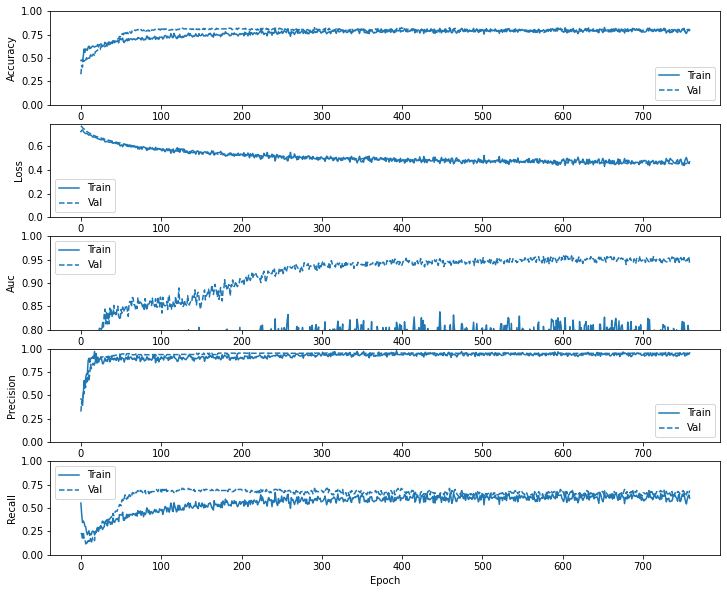

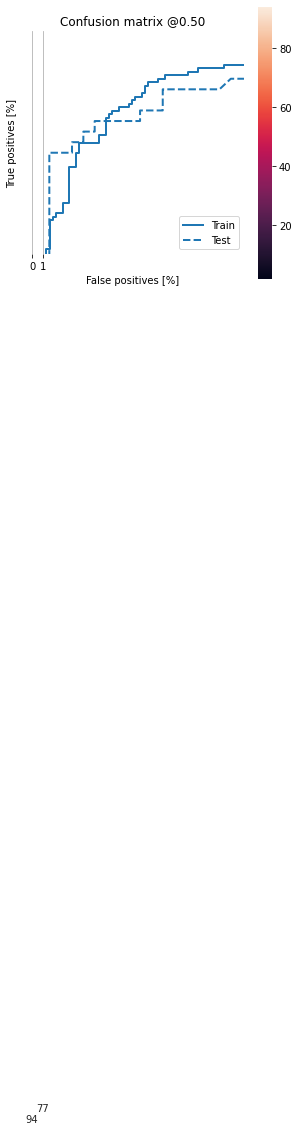

In [19]:
%%time
expId = 101
desc = str(expId) + " AngleEmbedding BasicEntanglerLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits)) 
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_101, history_101 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 1081s 83s/step - loss: 0.9316 - tp: 239.0000 - fp: 191.5000 - tn: 95.0000 - fn: 43.3571 - accuracy: 0.6094 - precision: 0.5827 - recall: 0.8378 - auc: 0.6783 - val_loss: 0.8180 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.6236
Epoch 2/10000
13/13 [==============================] - 1082s 83s/step - loss: 0.9255 - tp: 160.1429 - fp: 191.4286 - tn: 0.5000 - fn: 17.7857 - accuracy: 0.4268 - precision: 0.4473 - recall: 0.9002 - auc: 0.4849 - val_loss: 0.8084 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.6222
Epoch 3/10000
13/13 [==============================] - 1081s 83s/step - loss: 0.9329 - tp: 155.3571 - fp: 193.4286 - tn: 0.3571 - fn: 20.7143 - accuracy: 0.4123 - precision: 0.4350 - recall: 0.8878 - auc: 0.45

Epoch 22/10000
13/13 [==============================] - 1080s 83s/step - loss: 0.6746 - tp: 172.5000 - fp: 185.8571 - tn: 1.7143 - fn: 9.7857 - accuracy: 0.4751 - precision: 0.4872 - recall: 0.9433 - auc: 0.6439 - val_loss: 0.6282 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.8001
Epoch 23/10000
13/13 [==============================] - 1080s 83s/step - loss: 0.6668 - tp: 173.7857 - fp: 187.6429 - tn: 0.7857 - fn: 7.6429 - accuracy: 0.4768 - precision: 0.4859 - recall: 0.9595 - auc: 0.6366 - val_loss: 0.6210 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.8101
Epoch 24/10000
13/13 [==============================] - 1081s 83s/step - loss: 0.6724 - tp: 165.6429 - fp: 193.4286 - tn: 0.2857 - fn: 10.5000 - accuracy: 0.4513 - precision: 0.4658 - recall: 0.9348 - auc: 0.63

Epoch 43/10000
13/13 [==============================] - 1083s 83s/step - loss: 0.6046 - tp: 62.9286 - fp: 3.9286 - tn: 187.8571 - fn: 115.1429 - accuracy: 0.6835 - precision: 0.9374 - recall: 0.3642 - auc: 0.6645 - val_loss: 0.5661 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 24.0000 - val_accuracy: 0.7925 - val_precision: 0.8732 - val_recall: 0.7209 - val_auc: 0.8417
Epoch 44/10000
13/13 [==============================] - 1078s 83s/step - loss: 0.5941 - tp: 74.4286 - fp: 8.0714 - tn: 185.2143 - fn: 102.1429 - accuracy: 0.7209 - precision: 0.8990 - recall: 0.4575 - auc: 0.6916 - val_loss: 0.5653 - val_tp: 62.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 24.0000 - val_accuracy: 0.7987 - val_precision: 0.8857 - val_recall: 0.7209 - val_auc: 0.8265
Epoch 45/10000
13/13 [==============================] - 1085s 84s/step - loss: 0.6091 - tp: 69.3571 - fp: 9.2143 - tn: 182.0714 - fn: 109.2143 - accuracy: 0.6758 - precision: 0.8720 - recall: 0.3892 - auc: 0.6957 - val_los

13/13 [==============================] - 1084s 83s/step - loss: 0.5492 - tp: 77.4286 - fp: 6.8571 - tn: 186.7857 - fn: 98.7857 - accuracy: 0.7204 - precision: 0.9221 - recall: 0.4443 - auc: 0.7771 - val_loss: 0.5365 - val_tp: 62.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 24.0000 - val_accuracy: 0.7987 - val_precision: 0.8857 - val_recall: 0.7209 - val_auc: 0.8685
Epoch 86/10000
13/13 [==============================] - 1085s 84s/step - loss: 0.5530 - tp: 83.9286 - fp: 7.5714 - tn: 178.3571 - fn: 100.0000 - accuracy: 0.7086 - precision: 0.9262 - recall: 0.4579 - auc: 0.7926 - val_loss: 0.5312 - val_tp: 62.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 24.0000 - val_accuracy: 0.7987 - val_precision: 0.8857 - val_recall: 0.7209 - val_auc: 0.8690
Epoch 87/10000
13/13 [==============================] - 1083s 83s/step - loss: 0.5729 - tp: 67.0714 - fp: 5.0714 - tn: 184.5714 - fn: 113.1429 - accuracy: 0.6837 - precision: 0.9270 - recall: 0.3833 - auc: 0.7420 - val_loss: 0.5268 - val_

13/13 [==============================] - 1087s 84s/step - loss: 0.4926 - tp: 86.8571 - fp: 16.7143 - tn: 170.0000 - fn: 96.2857 - accuracy: 0.6952 - precision: 0.8473 - recall: 0.4852 - auc: 0.8268 - val_loss: 0.4579 - val_tp: 71.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 15.0000 - val_accuracy: 0.8491 - val_precision: 0.8875 - val_recall: 0.8256 - val_auc: 0.9194
Epoch 128/10000
13/13 [==============================] - 1085s 84s/step - loss: 0.5036 - tp: 82.4286 - fp: 14.9286 - tn: 175.3571 - fn: 97.1429 - accuracy: 0.6790 - precision: 0.8247 - recall: 0.4418 - auc: 0.8200 - val_loss: 0.4563 - val_tp: 74.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 12.0000 - val_accuracy: 0.8679 - val_precision: 0.8916 - val_recall: 0.8605 - val_auc: 0.9221
Epoch 129/10000
13/13 [==============================] - 1085s 84s/step - loss: 0.5201 - tp: 84.7143 - fp: 15.0714 - tn: 169.4286 - fn: 100.6429 - accuracy: 0.6860 - precision: 0.8740 - recall: 0.4577 - auc: 0.7906 - val_loss: 0.4598 - 

13/13 [==============================] - 1085s 84s/step - loss: 0.5095 - tp: 84.0000 - fp: 19.0714 - tn: 172.5714 - fn: 94.2143 - accuracy: 0.6837 - precision: 0.7968 - recall: 0.4648 - auc: 0.7863 - val_loss: 0.4394 - val_tp: 74.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 12.0000 - val_accuracy: 0.8805 - val_precision: 0.9136 - val_recall: 0.8605 - val_auc: 0.9297
Epoch 149/10000
13/13 [==============================] - 1085s 84s/step - loss: 0.4682 - tp: 95.6429 - fp: 14.1429 - tn: 172.5000 - fn: 87.5714 - accuracy: 0.7194 - precision: 0.8779 - recall: 0.5142 - auc: 0.8453 - val_loss: 0.4407 - val_tp: 74.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 12.0000 - val_accuracy: 0.8742 - val_precision: 0.9024 - val_recall: 0.8605 - val_auc: 0.9319
Epoch 150/10000
13/13 [==============================] - 1086s 84s/step - loss: 0.4774 - tp: 81.6429 - fp: 20.0000 - tn: 176.5714 - fn: 91.6429 - accuracy: 0.7054 - precision: 0.8000 - recall: 0.4880 - auc: 0.8128 - val_loss: 0.4395 - v

13/13 [==============================] - 1083s 83s/step - loss: 0.5247 - tp: 86.4286 - fp: 28.5000 - tn: 168.6429 - fn: 86.2857 - accuracy: 0.6884 - precision: 0.7419 - recall: 0.5056 - auc: 0.7689 - val_loss: 0.4226 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9424
Epoch 191/10000
13/13 [==============================] - 1085s 84s/step - loss: 0.5020 - tp: 91.5714 - fp: 29.9286 - tn: 163.0714 - fn: 85.2857 - accuracy: 0.6822 - precision: 0.7413 - recall: 0.5099 - auc: 0.7805 - val_loss: 0.4205 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9483
Epoch 192/10000
13/13 [==============================] - 1086s 84s/step - loss: 0.4790 - tp: 102.4286 - fp: 28.2143 - tn: 166.1429 - fn: 73.0714 - accuracy: 0.7272 - precision: 0.7751 - recall: 0.5914 - auc: 0.8102 - val_loss: 0.4196 - 

13/13 [==============================] - 1086s 84s/step - loss: 0.4654 - tp: 114.4286 - fp: 44.2857 - tn: 146.8571 - fn: 64.2857 - accuracy: 0.7144 - precision: 0.7278 - recall: 0.6508 - auc: 0.8339 - val_loss: 0.4169 - val_tp: 77.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 9.0000 - val_accuracy: 0.8994 - val_precision: 0.9167 - val_recall: 0.8953 - val_auc: 0.9427
Epoch 212/10000
13/13 [==============================] - 1089s 84s/step - loss: 0.4814 - tp: 106.5000 - fp: 39.2857 - tn: 154.1429 - fn: 69.9286 - accuracy: 0.7099 - precision: 0.7430 - recall: 0.6047 - auc: 0.8184 - val_loss: 0.4194 - val_tp: 75.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 11.0000 - val_accuracy: 0.8868 - val_precision: 0.9146 - val_recall: 0.8721 - val_auc: 0.9414
Epoch 213/10000
13/13 [==============================] - 1082s 83s/step - loss: 0.4906 - tp: 100.7857 - fp: 36.4286 - tn: 154.8571 - fn: 77.7857 - accuracy: 0.6845 - precision: 0.7224 - recall: 0.5497 - auc: 0.8065 - val_loss: 0.4211 -

13/13 [==============================] - 1085s 84s/step - loss: 0.5180 - tp: 89.2143 - fp: 43.2143 - tn: 154.0000 - fn: 83.4286 - accuracy: 0.6585 - precision: 0.6766 - recall: 0.5080 - auc: 0.7684 - val_loss: 0.4106 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9473
Epoch 233/10000
13/13 [==============================] - 1083s 83s/step - loss: 0.4636 - tp: 118.0714 - fp: 40.8571 - tn: 150.7857 - fn: 60.1429 - accuracy: 0.7353 - precision: 0.7528 - recall: 0.6633 - auc: 0.8488 - val_loss: 0.4118 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9428
Epoch 234/10000
13/13 [==============================] - 1083s 83s/step - loss: 0.4791 - tp: 109.8571 - fp: 45.7857 - tn: 147.7143 - fn: 66.5000 - accuracy: 0.6908 - precision: 0.6834 - recall: 0.6189 - auc: 0.8122 - val_loss: 0.4094 -

13/13 [==============================] - 1083s 83s/step - loss: 0.4796 - tp: 90.9286 - fp: 28.6429 - tn: 165.1429 - fn: 85.1429 - accuracy: 0.6918 - precision: 0.7514 - recall: 0.5133 - auc: 0.8014 - val_loss: 0.4067 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9478
Epoch 254/10000
13/13 [==============================] - 1083s 83s/step - loss: 0.4354 - tp: 104.3571 - fp: 31.0714 - tn: 158.8571 - fn: 75.5714 - accuracy: 0.7053 - precision: 0.7546 - recall: 0.5575 - auc: 0.8406 - val_loss: 0.4001 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9506
Epoch 255/10000
13/13 [==============================] - 1082s 83s/step - loss: 0.4917 - tp: 97.5714 - fp: 36.8571 - tn: 152.7143 - fn: 82.7143 - accuracy: 0.6730 - precision: 0.7134 - recall: 0.5464 - auc: 0.8017 - val_loss: 0.4027 - 

13/13 [==============================] - 1084s 83s/step - loss: 0.4688 - tp: 98.2857 - fp: 37.1429 - tn: 161.5714 - fn: 72.8571 - accuracy: 0.7174 - precision: 0.7106 - recall: 0.6078 - auc: 0.8124 - val_loss: 0.4036 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9468
Epoch 275/10000
13/13 [==============================] - 1083s 83s/step - loss: 0.4638 - tp: 105.3571 - fp: 42.0000 - tn: 149.0714 - fn: 73.4286 - accuracy: 0.6931 - precision: 0.7328 - recall: 0.5823 - auc: 0.8245 - val_loss: 0.4025 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9479
Epoch 276/10000
13/13 [==============================] - 1086s 84s/step - loss: 0.4702 - tp: 112.5000 - fp: 34.2143 - tn: 155.0000 - fn: 68.1429 - accuracy: 0.7230 - precision: 0.7636 - recall: 0.6323 - auc: 0.8247 - val_loss: 0.4054 -

13/13 [==============================] - 1083s 83s/step - loss: 0.4706 - tp: 96.2857 - fp: 32.0714 - tn: 157.0714 - fn: 84.4286 - accuracy: 0.6826 - precision: 0.7352 - recall: 0.5450 - auc: 0.8126 - val_loss: 0.4020 - val_tp: 75.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 11.0000 - val_accuracy: 0.8931 - val_precision: 0.9259 - val_recall: 0.8721 - val_auc: 0.9479
Epoch 296/10000
13/13 [==============================] - 1081s 83s/step - loss: 0.4535 - tp: 112.6429 - fp: 40.1429 - tn: 151.1429 - fn: 65.9286 - accuracy: 0.7115 - precision: 0.7337 - recall: 0.6369 - auc: 0.8295 - val_loss: 0.4015 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9474
Epoch 297/10000
13/13 [==============================] - 1082s 83s/step - loss: 0.4906 - tp: 98.9286 - fp: 32.2857 - tn: 160.2857 - fn: 78.3571 - accuracy: 0.6942 - precision: 0.7504 - recall: 0.5503 - auc: 0.8131 - val_loss: 0.4013 - 

13/13 [==============================] - 1083s 83s/step - loss: 0.4677 - tp: 99.0000 - fp: 39.7143 - tn: 150.7143 - fn: 80.4286 - accuracy: 0.6662 - precision: 0.7183 - recall: 0.5372 - auc: 0.7938 - val_loss: 0.3984 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9486
Epoch 317/10000
13/13 [==============================] - 1081s 83s/step - loss: 0.4339 - tp: 104.3571 - fp: 35.5714 - tn: 158.2143 - fn: 71.7143 - accuracy: 0.7197 - precision: 0.7521 - recall: 0.5992 - auc: 0.8441 - val_loss: 0.4003 - val_tp: 77.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 9.0000 - val_accuracy: 0.9057 - val_precision: 0.9277 - val_recall: 0.8953 - val_auc: 0.9446
Epoch 318/10000
13/13 [==============================] - 1083s 83s/step - loss: 0.4705 - tp: 100.7857 - fp: 31.5000 - tn: 163.2143 - fn: 74.3571 - accuracy: 0.7101 - precision: 0.7608 - recall: 0.5717 - auc: 0.8185 - val_loss: 0.3982 - v

13/13 [==============================] - 1084s 83s/step - loss: 0.4786 - tp: 94.5000 - fp: 32.1429 - tn: 167.7857 - fn: 75.4286 - accuracy: 0.7041 - precision: 0.7287 - recall: 0.5572 - auc: 0.8125 - val_loss: 0.3944 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9452
Epoch 338/10000
13/13 [==============================] - 1084s 83s/step - loss: 0.4981 - tp: 95.7143 - fp: 40.7857 - tn: 155.6429 - fn: 77.7143 - accuracy: 0.6799 - precision: 0.6919 - recall: 0.5466 - auc: 0.7781 - val_loss: 0.3951 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9496
Epoch 339/10000
13/13 [==============================] - 1081s 83s/step - loss: 0.4514 - tp: 103.6429 - fp: 40.0714 - tn: 148.5714 - fn: 77.5714 - accuracy: 0.6786 - precision: 0.7398 - recall: 0.5586 - auc: 0.8269 - val_loss: 0.3943 - v

13/13 [==============================] - 1081s 83s/step - loss: 0.4692 - tp: 89.1429 - fp: 28.7143 - tn: 162.3571 - fn: 89.6429 - accuracy: 0.6844 - precision: 0.7818 - recall: 0.4860 - auc: 0.8151 - val_loss: 0.3946 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9509
Epoch 359/10000
13/13 [==============================] - 1080s 83s/step - loss: 0.4912 - tp: 105.1429 - fp: 41.5714 - tn: 145.9286 - fn: 77.2143 - accuracy: 0.6827 - precision: 0.7262 - recall: 0.5784 - auc: 0.7791 - val_loss: 0.3920 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9492
Epoch 360/10000
13/13 [==============================] - 1081s 83s/step - loss: 0.4882 - tp: 104.7857 - fp: 42.0000 - tn: 147.0000 - fn: 76.0714 - accuracy: 0.6892 - precision: 0.7217 - recall: 0.5950 - auc: 0.8114 - val_loss: 0.3943 -

13/13 [==============================] - 1080s 83s/step - loss: 0.4569 - tp: 99.0000 - fp: 38.2143 - tn: 153.9286 - fn: 78.7143 - accuracy: 0.6888 - precision: 0.7276 - recall: 0.5731 - auc: 0.8241 - val_loss: 0.3951 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9501
Epoch 380/10000
13/13 [==============================] - 1082s 83s/step - loss: 0.4511 - tp: 95.2857 - fp: 31.0000 - tn: 163.5714 - fn: 80.0000 - accuracy: 0.7023 - precision: 0.7514 - recall: 0.5512 - auc: 0.8305 - val_loss: 0.3936 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9501
Epoch 381/10000
13/13 [==============================] - 1077s 83s/step - loss: 0.4661 - tp: 115.2143 - fp: 40.1429 - tn: 154.0000 - fn: 60.5000 - accuracy: 0.7305 - precision: 0.7455 - recall: 0.6627 - auc: 0.8360 - val_loss: 0.3891 - v

13/13 [==============================] - 1079s 83s/step - loss: 0.4969 - tp: 94.6429 - fp: 31.7143 - tn: 158.5000 - fn: 85.0000 - accuracy: 0.6730 - precision: 0.7513 - recall: 0.5154 - auc: 0.7928 - val_loss: 0.3902 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9487
Epoch 401/10000
13/13 [==============================] - 1082s 83s/step - loss: 0.4437 - tp: 102.9286 - fp: 31.0000 - tn: 162.5714 - fn: 73.3571 - accuracy: 0.7233 - precision: 0.7774 - recall: 0.5900 - auc: 0.8389 - val_loss: 0.3903 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9474
Epoch 402/10000
13/13 [==============================] - 1083s 83s/step - loss: 0.5071 - tp: 97.9286 - fp: 34.3571 - tn: 157.2143 - fn: 80.3571 - accuracy: 0.6723 - precision: 0.7238 - recall: 0.5266 - auc: 0.7823 - val_loss: 0.3923 - 

13/13 [==============================] - 1079s 83s/step - loss: 0.4309 - tp: 102.6429 - fp: 29.0714 - tn: 165.7857 - fn: 72.3571 - accuracy: 0.7234 - precision: 0.7716 - recall: 0.5712 - auc: 0.8513 - val_loss: 0.3835 - val_tp: 77.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 9.0000 - val_accuracy: 0.9057 - val_precision: 0.9277 - val_recall: 0.8953 - val_auc: 0.9530
Epoch 422/10000
13/13 [==============================] - 1083s 83s/step - loss: 0.4668 - tp: 100.5000 - fp: 37.0714 - tn: 154.9286 - fn: 77.3571 - accuracy: 0.6845 - precision: 0.7141 - recall: 0.5517 - auc: 0.8027 - val_loss: 0.3851 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9515
Epoch 423/10000
13/13 [==============================] - 1076s 83s/step - loss: 0.5052 - tp: 103.7143 - fp: 38.1429 - tn: 145.5000 - fn: 82.5000 - accuracy: 0.6691 - precision: 0.7490 - recall: 0.5487 - auc: 0.7762 - val_loss: 0.3862 - 

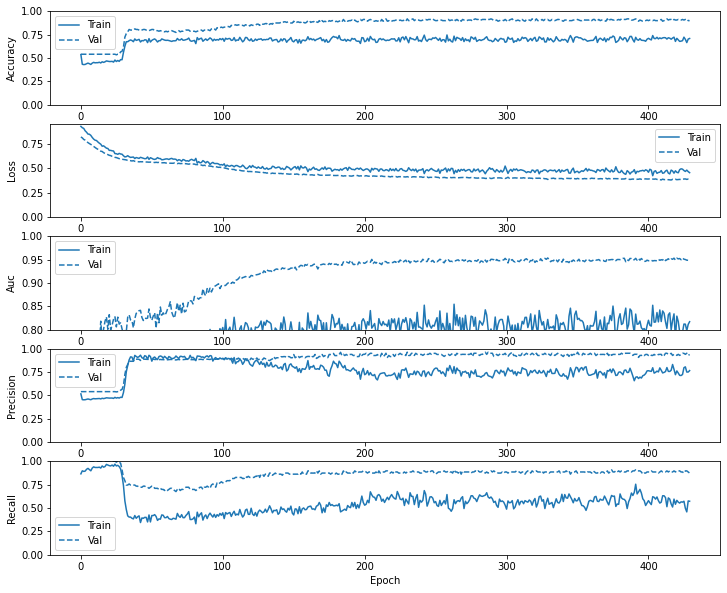

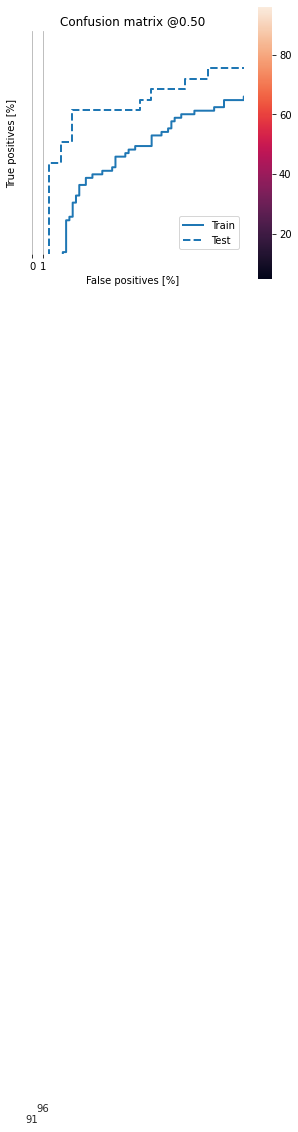

In [20]:
%%time
expId = 102
desc = str(expId) + " AngleEmbedding RandomLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.RandomLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_102, history_102 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 1900s 146s/step - loss: 0.6940 - tp: 125.8571 - fp: 182.5714 - tn: 7.9286 - fn: 53.5000 - accuracy: 0.3697 - precision: 0.4111 - recall: 0.7232 - auc: 0.4343 - val_loss: 0.6804 - val_tp: 77.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 9.0000 - val_accuracy: 0.4843 - val_precision: 0.5133 - val_recall: 0.8953 - val_auc: 0.5933
Epoch 2/10000
13/13 [==============================] - 1891s 145s/step - loss: 0.6906 - tp: 118.3571 - fp: 188.0000 - tn: 3.9286 - fn: 59.5714 - accuracy: 0.3282 - precision: 0.3818 - recall: 0.6784 - auc: 0.4202 - val_loss: 0.6727 - val_tp: 78.0000 - val_fp: 68.0000 - val_tn: 5.0000 - val_fn: 8.0000 - val_accuracy: 0.5220 - val_precision: 0.5342 - val_recall: 0.9070 - val_auc: 0.6751
Epoch 3/10000
13/13 [==============================] - 1897s 146s/step - loss: 0.6755 - tp: 100.8571 - fp: 143.0714 - tn: 50.7143 - fn: 75.2143 - accuracy: 0.4039 - precision: 0.4055 - recall: 0.6020 - auc: 0.4819 - val_

13/13 [==============================] - 1892s 145s/step - loss: 0.6128 - tp: 64.6429 - fp: 8.9286 - tn: 178.6429 - fn: 117.6429 - accuracy: 0.6555 - precision: 0.8870 - recall: 0.3563 - auc: 0.7279 - val_loss: 0.6062 - val_tp: 46.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 40.0000 - val_accuracy: 0.7358 - val_precision: 0.9583 - val_recall: 0.5349 - val_auc: 0.7606
Epoch 23/10000
13/13 [==============================] - 1894s 146s/step - loss: 0.6287 - tp: 53.3571 - fp: 6.6429 - tn: 181.7857 - fn: 128.0714 - accuracy: 0.6280 - precision: 0.8993 - recall: 0.2819 - auc: 0.7216 - val_loss: 0.6024 - val_tp: 46.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 40.0000 - val_accuracy: 0.7358 - val_precision: 0.9583 - val_recall: 0.5349 - val_auc: 0.8049
Epoch 24/10000
13/13 [==============================] - 1891s 145s/step - loss: 0.6081 - tp: 55.8571 - fp: 6.3571 - tn: 187.3571 - fn: 120.2857 - accuracy: 0.6585 - precision: 0.9051 - recall: 0.3245 - auc: 0.7551 - val_loss: 0.6003 - 

13/13 [==============================] - 1888s 145s/step - loss: 0.6093 - tp: 61.1429 - fp: 7.2143 - tn: 184.5714 - fn: 116.9286 - accuracy: 0.6645 - precision: 0.9042 - recall: 0.3369 - auc: 0.7317 - val_loss: 0.5845 - val_tp: 45.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 41.0000 - val_accuracy: 0.7233 - val_precision: 0.9375 - val_recall: 0.5233 - val_auc: 0.8381
Epoch 44/10000
13/13 [==============================] - 1888s 145s/step - loss: 0.6103 - tp: 57.7857 - fp: 4.8571 - tn: 188.4286 - fn: 118.7857 - accuracy: 0.6671 - precision: 0.8951 - recall: 0.3252 - auc: 0.7414 - val_loss: 0.5825 - val_tp: 46.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 40.0000 - val_accuracy: 0.7296 - val_precision: 0.9388 - val_recall: 0.5349 - val_auc: 0.8507
Epoch 45/10000
13/13 [==============================] - 1886s 145s/step - loss: 0.5970 - tp: 68.5000 - fp: 6.5714 - tn: 184.7143 - fn: 110.0714 - accuracy: 0.6763 - precision: 0.9048 - recall: 0.3720 - auc: 0.7454 - val_loss: 0.5814 - 

13/13 [==============================] - 1886s 145s/step - loss: 0.6002 - tp: 68.7143 - fp: 5.5000 - tn: 186.1429 - fn: 109.5000 - accuracy: 0.6761 - precision: 0.9394 - recall: 0.3594 - auc: 0.6909 - val_loss: 0.5664 - val_tp: 46.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 40.0000 - val_accuracy: 0.7296 - val_precision: 0.9388 - val_recall: 0.5349 - val_auc: 0.8805
Epoch 65/10000
13/13 [==============================] - 1889s 145s/step - loss: 0.5905 - tp: 69.5714 - fp: 7.6429 - tn: 183.9286 - fn: 108.7143 - accuracy: 0.6829 - precision: 0.8994 - recall: 0.3824 - auc: 0.7132 - val_loss: 0.5637 - val_tp: 48.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 38.0000 - val_accuracy: 0.7421 - val_precision: 0.9412 - val_recall: 0.5581 - val_auc: 0.8938
Epoch 66/10000
13/13 [==============================] - 1892s 146s/step - loss: 0.5555 - tp: 81.5714 - fp: 5.5000 - tn: 187.1429 - fn: 95.6429 - accuracy: 0.7401 - precision: 0.9447 - recall: 0.4817 - auc: 0.7328 - val_loss: 0.5642 - v

13/13 [==============================] - 1885s 145s/step - loss: 0.5829 - tp: 73.5714 - fp: 7.4286 - tn: 186.2143 - fn: 102.6429 - accuracy: 0.7014 - precision: 0.9102 - recall: 0.4046 - auc: 0.7153 - val_loss: 0.5567 - val_tp: 52.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 34.0000 - val_accuracy: 0.7673 - val_precision: 0.9455 - val_recall: 0.6047 - val_auc: 0.8905
Epoch 86/10000
13/13 [==============================] - 1889s 145s/step - loss: 0.5704 - tp: 86.3571 - fp: 6.7143 - tn: 179.2143 - fn: 97.5714 - accuracy: 0.7142 - precision: 0.9295 - recall: 0.4682 - auc: 0.7052 - val_loss: 0.5559 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.8912
Epoch 87/10000
13/13 [==============================] - 1888s 145s/step - loss: 0.5644 - tp: 77.6429 - fp: 8.6429 - tn: 181.0000 - fn: 102.5714 - accuracy: 0.7099 - precision: 0.8975 - recall: 0.4602 - auc: 0.7215 - val_loss: 0.5549 - v

13/13 [==============================] - 1890s 145s/step - loss: 0.5533 - tp: 89.8571 - fp: 7.1429 - tn: 180.7143 - fn: 92.1429 - accuracy: 0.7274 - precision: 0.9317 - recall: 0.4924 - auc: 0.7311 - val_loss: 0.5448 - val_tp: 53.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 33.0000 - val_accuracy: 0.7673 - val_precision: 0.9298 - val_recall: 0.6163 - val_auc: 0.9120
Epoch 107/10000
13/13 [==============================] - 1890s 145s/step - loss: 0.5716 - tp: 83.6429 - fp: 6.0714 - tn: 182.9286 - fn: 97.2143 - accuracy: 0.7209 - precision: 0.9364 - recall: 0.4546 - auc: 0.7222 - val_loss: 0.5466 - val_tp: 54.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 32.0000 - val_accuracy: 0.7736 - val_precision: 0.9310 - val_recall: 0.6279 - val_auc: 0.9033
Epoch 108/10000
13/13 [==============================] - 1893s 146s/step - loss: 0.5638 - tp: 83.3571 - fp: 9.4286 - tn: 180.1429 - fn: 96.9286 - accuracy: 0.7082 - precision: 0.8707 - recall: 0.4698 - auc: 0.7268 - val_loss: 0.5437 - v

13/13 [==============================] - 1886s 145s/step - loss: 0.5617 - tp: 82.2857 - fp: 9.0000 - tn: 177.7143 - fn: 100.8571 - accuracy: 0.7066 - precision: 0.9101 - recall: 0.4663 - auc: 0.7280 - val_loss: 0.5389 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.9114
Epoch 128/10000
13/13 [==============================] - 1888s 145s/step - loss: 0.5647 - tp: 79.0714 - fp: 8.1429 - tn: 182.1429 - fn: 100.5000 - accuracy: 0.7030 - precision: 0.9117 - recall: 0.4392 - auc: 0.7292 - val_loss: 0.5404 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.9039
Epoch 129/10000
13/13 [==============================] - 1885s 145s/step - loss: 0.5778 - tp: 81.3571 - fp: 8.0714 - tn: 176.4286 - fn: 104.0000 - accuracy: 0.6959 - precision: 0.9303 - recall: 0.4424 - auc: 0.7300 - val_loss: 0.5378 

13/13 [==============================] - 1890s 145s/step - loss: 0.5532 - tp: 84.7143 - fp: 10.2143 - tn: 181.4286 - fn: 93.5000 - accuracy: 0.7170 - precision: 0.8849 - recall: 0.4756 - auc: 0.7538 - val_loss: 0.5312 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.9184
Epoch 149/10000
13/13 [==============================] - 1886s 145s/step - loss: 0.5858 - tp: 84.4286 - fp: 10.1429 - tn: 176.5000 - fn: 98.7857 - accuracy: 0.6831 - precision: 0.8760 - recall: 0.4316 - auc: 0.6873 - val_loss: 0.5299 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.9136
Epoch 150/10000
13/13 [==============================] - 1888s 145s/step - loss: 0.5495 - tp: 79.7143 - fp: 5.8571 - tn: 190.7143 - fn: 93.5714 - accuracy: 0.7331 - precision: 0.9283 - recall: 0.4602 - auc: 0.7296 - val_loss: 0.5302 -

13/13 [==============================] - 1885s 145s/step - loss: 0.5530 - tp: 88.3571 - fp: 7.7857 - tn: 183.2143 - fn: 90.5000 - accuracy: 0.7294 - precision: 0.9344 - recall: 0.4837 - auc: 0.7274 - val_loss: 0.5241 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9188
Epoch 170/10000
13/13 [==============================] - 1892s 145s/step - loss: 0.5490 - tp: 86.3571 - fp: 8.2857 - tn: 186.0714 - fn: 89.1429 - accuracy: 0.7337 - precision: 0.8947 - recall: 0.4867 - auc: 0.7410 - val_loss: 0.5226 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.9261
Epoch 171/10000
13/13 [==============================] - 1896s 145s/step - loss: 0.5337 - tp: 84.5714 - fp: 7.0000 - tn: 187.5000 - fn: 90.7857 - accuracy: 0.7419 - precision: 0.9237 - recall: 0.4950 - auc: 0.7492 - val_loss: 0.5253 - v

13/13 [==============================] - 1722s 132s/step - loss: 0.5315 - tp: 84.6429 - fp: 8.8571 - tn: 188.2857 - fn: 88.0714 - accuracy: 0.7422 - precision: 0.9042 - recall: 0.4957 - auc: 0.7261 - val_loss: 0.5195 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.9145
Epoch 191/10000
13/13 [==============================] - 1721s 132s/step - loss: 0.5457 - tp: 83.9286 - fp: 7.0000 - tn: 186.0000 - fn: 92.9286 - accuracy: 0.7279 - precision: 0.9120 - recall: 0.4746 - auc: 0.7578 - val_loss: 0.5179 - val_tp: 58.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 28.0000 - val_accuracy: 0.7987 - val_precision: 0.9355 - val_recall: 0.6744 - val_auc: 0.9207
Epoch 192/10000
13/13 [==============================] - 1722s 132s/step - loss: 0.5170 - tp: 96.6429 - fp: 7.4286 - tn: 186.9286 - fn: 78.8571 - accuracy: 0.7727 - precision: 0.9416 - recall: 0.5500 - auc: 0.7835 - val_loss: 0.5175 - v

13/13 [==============================] - 1722s 132s/step - loss: 0.5317 - tp: 92.0000 - fp: 2.7857 - tn: 188.3571 - fn: 86.7143 - accuracy: 0.7543 - precision: 0.9737 - recall: 0.5049 - auc: 0.7439 - val_loss: 0.5115 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9252
Epoch 212/10000
13/13 [==============================] - 1725s 133s/step - loss: 0.5661 - tp: 77.5714 - fp: 11.0000 - tn: 182.4286 - fn: 98.8571 - accuracy: 0.6970 - precision: 0.8735 - recall: 0.4328 - auc: 0.7393 - val_loss: 0.5135 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.9225
Epoch 213/10000
13/13 [==============================] - 1722s 132s/step - loss: 0.5500 - tp: 87.1429 - fp: 10.5714 - tn: 180.7143 - fn: 91.4286 - accuracy: 0.7177 - precision: 0.8750 - recall: 0.4754 - auc: 0.7045 - val_loss: 0.5109 -

13/13 [==============================] - 1690s 130s/step - loss: 0.5308 - tp: 81.9286 - fp: 7.4286 - tn: 189.7857 - fn: 90.7143 - accuracy: 0.7439 - precision: 0.9230 - recall: 0.4879 - auc: 0.7421 - val_loss: 0.5098 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.9216
Epoch 233/10000
13/13 [==============================] - 1649s 127s/step - loss: 0.5699 - tp: 75.0714 - fp: 7.2857 - tn: 184.3571 - fn: 103.1429 - accuracy: 0.7014 - precision: 0.9199 - recall: 0.4079 - auc: 0.6986 - val_loss: 0.5111 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.9231
Epoch 234/10000
13/13 [==============================] - 1651s 127s/step - loss: 0.5414 - tp: 82.2857 - fp: 5.6429 - tn: 187.8571 - fn: 94.0714 - accuracy: 0.7371 - precision: 0.9401 - recall: 0.4627 - auc: 0.7683 - val_loss: 0.5116 - 

13/13 [==============================] - 1650s 127s/step - loss: 0.5134 - tp: 93.2143 - fp: 5.7143 - tn: 188.0714 - fn: 82.8571 - accuracy: 0.7643 - precision: 0.9340 - recall: 0.5369 - auc: 0.7409 - val_loss: 0.5062 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.9148
Epoch 254/10000
13/13 [==============================] - 1650s 127s/step - loss: 0.5058 - tp: 96.5714 - fp: 7.0000 - tn: 182.9286 - fn: 83.3571 - accuracy: 0.7603 - precision: 0.9306 - recall: 0.5390 - auc: 0.7816 - val_loss: 0.5103 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.9180
Epoch 255/10000
13/13 [==============================] - 1650s 127s/step - loss: 0.5190 - tp: 92.0714 - fp: 4.1429 - tn: 185.4286 - fn: 88.2143 - accuracy: 0.7541 - precision: 0.9677 - recall: 0.5092 - auc: 0.7488 - val_loss: 0.5071 - v

13/13 [==============================] - 1612s 124s/step - loss: 0.5175 - tp: 84.7143 - fp: 6.1429 - tn: 192.5714 - fn: 86.4286 - accuracy: 0.7680 - precision: 0.9232 - recall: 0.5180 - auc: 0.7888 - val_loss: 0.5112 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9353
Epoch 275/10000
13/13 [==============================] - 1613s 124s/step - loss: 0.5134 - tp: 94.2857 - fp: 6.6429 - tn: 184.4286 - fn: 84.5000 - accuracy: 0.7569 - precision: 0.9413 - recall: 0.5319 - auc: 0.7642 - val_loss: 0.5137 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9256
Epoch 276/10000
13/13 [==============================] - 1612s 124s/step - loss: 0.5572 - tp: 85.6429 - fp: 4.1429 - tn: 185.0714 - fn: 95.0000 - accuracy: 0.7233 - precision: 0.9570 - recall: 0.4575 - auc: 0.7310 - val_loss: 0.5138 - v

13/13 [==============================] - 1613s 124s/step - loss: 0.5143 - tp: 96.9286 - fp: 9.2143 - tn: 179.9286 - fn: 83.7857 - accuracy: 0.7520 - precision: 0.9112 - recall: 0.5424 - auc: 0.7697 - val_loss: 0.5173 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9188
Epoch 296/10000
13/13 [==============================] - 1612s 124s/step - loss: 0.5481 - tp: 90.1429 - fp: 9.1429 - tn: 182.1429 - fn: 88.4286 - accuracy: 0.7203 - precision: 0.8873 - recall: 0.4856 - auc: 0.7661 - val_loss: 0.5155 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9317
Epoch 297/10000
13/13 [==============================] - 1614s 124s/step - loss: 0.5037 - tp: 95.0000 - fp: 6.7143 - tn: 185.8571 - fn: 82.2857 - accuracy: 0.7591 - precision: 0.9257 - recall: 0.5459 - auc: 0.7857 - val_loss: 0.5153 - v

13/13 [==============================] - 1594s 123s/step - loss: 0.5250 - tp: 91.6429 - fp: 7.2857 - tn: 183.1429 - fn: 87.7857 - accuracy: 0.7337 - precision: 0.9170 - recall: 0.5091 - auc: 0.7992 - val_loss: 0.5271 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9285
Epoch 317/10000
13/13 [==============================] - 1594s 123s/step - loss: 0.4967 - tp: 94.7857 - fp: 3.6429 - tn: 190.1429 - fn: 81.2857 - accuracy: 0.7757 - precision: 0.9590 - recall: 0.5447 - auc: 0.7952 - val_loss: 0.5223 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9331
Epoch 318/10000
13/13 [==============================] - 1593s 123s/step - loss: 0.5036 - tp: 90.9286 - fp: 5.5714 - tn: 189.1429 - fn: 84.2143 - accuracy: 0.7636 - precision: 0.9521 - recall: 0.5302 - auc: 0.8132 - val_loss: 0.5253 - v

13/13 [==============================] - 1598s 123s/step - loss: 0.5283 - tp: 86.2857 - fp: 8.2143 - tn: 191.7143 - fn: 83.6429 - accuracy: 0.7453 - precision: 0.8948 - recall: 0.4943 - auc: 0.7455 - val_loss: 0.5307 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9385
Epoch 338/10000
13/13 [==============================] - 1598s 123s/step - loss: 0.5315 - tp: 84.0714 - fp: 6.0000 - tn: 190.4286 - fn: 89.3571 - accuracy: 0.7474 - precision: 0.9386 - recall: 0.4823 - auc: 0.7539 - val_loss: 0.5366 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9158
Epoch 339/10000
13/13 [==============================] - 1597s 123s/step - loss: 0.5122 - tp: 100.1429 - fp: 5.5000 - tn: 183.1429 - fn: 81.0714 - accuracy: 0.7583 - precision: 0.9520 - recall: 0.5470 - auc: 0.7781 - val_loss: 0.5348 - 

13/13 [==============================] - 1597s 123s/step - loss: 0.5097 - tp: 97.8571 - fp: 6.5714 - tn: 184.5000 - fn: 80.9286 - accuracy: 0.7713 - precision: 0.9472 - recall: 0.5576 - auc: 0.7662 - val_loss: 0.5302 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9367
Epoch 359/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.4983 - tp: 105.5000 - fp: 5.9286 - tn: 181.5714 - fn: 76.8571 - accuracy: 0.7739 - precision: 0.9555 - recall: 0.5704 - auc: 0.7939 - val_loss: 0.5289 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9360
Epoch 360/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.5386 - tp: 96.0000 - fp: 10.2857 - tn: 178.7143 - fn: 84.8571 - accuracy: 0.7397 - precision: 0.9000 - recall: 0.5275 - auc: 0.7540 - val_loss: 0.5296 -

13/13 [==============================] - 1597s 123s/step - loss: 0.4979 - tp: 102.8571 - fp: 4.2143 - tn: 187.9286 - fn: 74.8571 - accuracy: 0.7859 - precision: 0.9620 - recall: 0.5825 - auc: 0.7747 - val_loss: 0.5302 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9372
Epoch 380/10000
13/13 [==============================] - 1599s 123s/step - loss: 0.5164 - tp: 94.6429 - fp: 6.0714 - tn: 188.5000 - fn: 80.6429 - accuracy: 0.7682 - precision: 0.9322 - recall: 0.5480 - auc: 0.7571 - val_loss: 0.5309 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9283
Epoch 381/10000
13/13 [==============================] - 1598s 123s/step - loss: 0.4740 - tp: 106.2857 - fp: 6.6429 - tn: 187.5000 - fn: 69.4286 - accuracy: 0.7940 - precision: 0.9406 - recall: 0.6082 - auc: 0.8124 - val_loss: 0.5311 -

13/13 [==============================] - 1598s 123s/step - loss: 0.5107 - tp: 100.7143 - fp: 6.1429 - tn: 184.0714 - fn: 78.9286 - accuracy: 0.7580 - precision: 0.9386 - recall: 0.5514 - auc: 0.7698 - val_loss: 0.5214 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9335
Epoch 401/10000
13/13 [==============================] - 1598s 123s/step - loss: 0.4800 - tp: 101.4286 - fp: 7.7143 - tn: 185.8571 - fn: 74.8571 - accuracy: 0.7837 - precision: 0.9348 - recall: 0.5872 - auc: 0.7893 - val_loss: 0.5200 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9361
Epoch 402/10000
13/13 [==============================] - 1597s 123s/step - loss: 0.5165 - tp: 102.3571 - fp: 7.2143 - tn: 184.3571 - fn: 75.9286 - accuracy: 0.7638 - precision: 0.9310 - recall: 0.5565 - auc: 0.7668 - val_loss: 0.5199 

13/13 [==============================] - 1598s 123s/step - loss: 0.4823 - tp: 103.5714 - fp: 4.0714 - tn: 190.7857 - fn: 71.4286 - accuracy: 0.8010 - precision: 0.9631 - recall: 0.5953 - auc: 0.7966 - val_loss: 0.5228 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9353
Epoch 422/10000
13/13 [==============================] - 1600s 123s/step - loss: 0.4988 - tp: 107.0000 - fp: 8.5714 - tn: 183.4286 - fn: 70.8571 - accuracy: 0.7776 - precision: 0.9034 - recall: 0.5910 - auc: 0.7959 - val_loss: 0.5214 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9384
Epoch 423/10000
13/13 [==============================] - 1598s 123s/step - loss: 0.5431 - tp: 99.4286 - fp: 7.2143 - tn: 176.4286 - fn: 86.7857 - accuracy: 0.7320 - precision: 0.9259 - recall: 0.5270 - auc: 0.7582 - val_loss: 0.5205 -

13/13 [==============================] - 1598s 123s/step - loss: 0.5152 - tp: 98.9286 - fp: 7.8571 - tn: 181.2143 - fn: 81.8571 - accuracy: 0.7534 - precision: 0.9220 - recall: 0.5385 - auc: 0.7893 - val_loss: 0.5144 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9373
Epoch 443/10000
13/13 [==============================] - 1597s 123s/step - loss: 0.4951 - tp: 106.7857 - fp: 9.1429 - tn: 182.5000 - fn: 71.4286 - accuracy: 0.7757 - precision: 0.9108 - recall: 0.6002 - auc: 0.7938 - val_loss: 0.5197 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9397
Epoch 444/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.4819 - tp: 102.7857 - fp: 7.4286 - tn: 188.1429 - fn: 71.5000 - accuracy: 0.7972 - precision: 0.9366 - recall: 0.6075 - auc: 0.7875 - val_loss: 0.5199 -

Epoch 463/10000
13/13 [==============================] - 1598s 123s/step - loss: 0.4944 - tp: 96.0000 - fp: 4.2143 - tn: 188.0714 - fn: 81.5714 - accuracy: 0.7741 - precision: 0.9640 - recall: 0.5508 - auc: 0.7870 - val_loss: 0.5115 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9393
Epoch 464/10000
13/13 [==============================] - 1597s 123s/step - loss: 0.4930 - tp: 105.0000 - fp: 8.7143 - tn: 179.8571 - fn: 76.2857 - accuracy: 0.7749 - precision: 0.9305 - recall: 0.5852 - auc: 0.7789 - val_loss: 0.5098 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9400
Epoch 465/10000
13/13 [==============================] - 1597s 123s/step - loss: 0.4530 - tp: 114.7857 - fp: 6.2857 - tn: 187.2857 - fn: 61.5000 - accuracy: 0.8240 - precision: 0.9500 - recall: 0.6595 - auc: 0.8101 - va

Epoch 484/10000
13/13 [==============================] - 1597s 123s/step - loss: 0.5082 - tp: 107.6429 - fp: 7.5714 - tn: 172.0000 - fn: 82.6429 - accuracy: 0.7527 - precision: 0.9358 - recall: 0.5679 - auc: 0.8027 - val_loss: 0.5138 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9345
Epoch 485/10000
13/13 [==============================] - 1595s 123s/step - loss: 0.4904 - tp: 109.0000 - fp: 6.8571 - tn: 183.5714 - fn: 70.4286 - accuracy: 0.7832 - precision: 0.9363 - recall: 0.5875 - auc: 0.7816 - val_loss: 0.5110 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9469
Epoch 486/10000
13/13 [==============================] - 1595s 123s/step - loss: 0.4798 - tp: 105.9286 - fp: 7.9286 - tn: 187.7143 - fn: 68.2857 - accuracy: 0.7870 - precision: 0.9204 - recall: 0.6050 - auc: 0.7905 - v

Epoch 505/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.5043 - tp: 107.6429 - fp: 6.0000 - tn: 177.6429 - fn: 78.5714 - accuracy: 0.7554 - precision: 0.9436 - recall: 0.5655 - auc: 0.7939 - val_loss: 0.5101 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9386
Epoch 506/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.4806 - tp: 110.0714 - fp: 5.5000 - tn: 184.7857 - fn: 69.5000 - accuracy: 0.7952 - precision: 0.9480 - recall: 0.5991 - auc: 0.7857 - val_loss: 0.5068 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9407
Epoch 507/10000
13/13 [==============================] - 1595s 123s/step - loss: 0.4886 - tp: 103.0000 - fp: 7.0000 - tn: 186.5000 - fn: 73.3571 - accuracy: 0.7824 - precision: 0.9325 - recall: 0.5762 - auc: 0.7828 - v

Epoch 526/10000
13/13 [==============================] - 1600s 123s/step - loss: 0.4994 - tp: 101.2857 - fp: 9.1429 - tn: 183.0714 - fn: 76.3571 - accuracy: 0.7645 - precision: 0.9083 - recall: 0.5726 - auc: 0.7578 - val_loss: 0.5051 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9493
Epoch 527/10000
13/13 [==============================] - 1599s 123s/step - loss: 0.4922 - tp: 105.6429 - fp: 6.1429 - tn: 185.7143 - fn: 72.3571 - accuracy: 0.7832 - precision: 0.9462 - recall: 0.5797 - auc: 0.7742 - val_loss: 0.5059 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9397
Epoch 528/10000
13/13 [==============================] - 1599s 123s/step - loss: 0.4676 - tp: 109.3571 - fp: 5.2143 - tn: 186.3571 - fn: 68.9286 - accuracy: 0.7988 - precision: 0.9535 - recall: 0.6181 - auc: 0.8217 - v

Epoch 547/10000
13/13 [==============================] - 1595s 123s/step - loss: 0.4735 - tp: 115.0000 - fp: 9.6429 - tn: 180.8571 - fn: 64.3571 - accuracy: 0.7982 - precision: 0.9235 - recall: 0.6427 - auc: 0.8068 - val_loss: 0.5026 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9422
Epoch 548/10000
13/13 [==============================] - 1595s 123s/step - loss: 0.4579 - tp: 108.5714 - fp: 5.9286 - tn: 188.3571 - fn: 67.0000 - accuracy: 0.8168 - precision: 0.9514 - recall: 0.6447 - auc: 0.8055 - val_loss: 0.5021 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9357
Epoch 549/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.5003 - tp: 105.7143 - fp: 7.5000 - tn: 180.2857 - fn: 76.3571 - accuracy: 0.7659 - precision: 0.9326 - recall: 0.5609 - auc: 0.7479 - v

Epoch 568/10000
13/13 [==============================] - 1595s 123s/step - loss: 0.4865 - tp: 104.5000 - fp: 4.7143 - tn: 185.0000 - fn: 75.6429 - accuracy: 0.7777 - precision: 0.9654 - recall: 0.5643 - auc: 0.7803 - val_loss: 0.4936 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9486
Epoch 569/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.5117 - tp: 100.0000 - fp: 6.9286 - tn: 184.1429 - fn: 78.7857 - accuracy: 0.7689 - precision: 0.9397 - recall: 0.5450 - auc: 0.7381 - val_loss: 0.4973 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9465
Epoch 570/10000
13/13 [==============================] - 1597s 123s/step - loss: 0.4753 - tp: 109.4286 - fp: 7.2143 - tn: 181.2857 - fn: 71.9286 - accuracy: 0.7875 - precision: 0.9450 - recall: 0.6043 - auc: 0.8029 - v

Epoch 589/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.4674 - tp: 109.9286 - fp: 3.5714 - tn: 191.2143 - fn: 65.1429 - accuracy: 0.8153 - precision: 0.9760 - recall: 0.6121 - auc: 0.7737 - val_loss: 0.4852 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9492
Epoch 590/10000
13/13 [==============================] - 1595s 123s/step - loss: 0.4939 - tp: 107.8571 - fp: 8.4286 - tn: 178.0000 - fn: 75.5714 - accuracy: 0.7818 - precision: 0.9355 - recall: 0.6032 - auc: 0.7770 - val_loss: 0.4885 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9486
Epoch 591/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.4500 - tp: 107.3571 - fp: 3.3571 - tn: 191.2143 - fn: 67.9286 - accuracy: 0.8130 - precision: 0.9787 - recall: 0.6184 - auc: 0.7933 - v

Epoch 610/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.5156 - tp: 92.8571 - fp: 6.7143 - tn: 190.0000 - fn: 80.2857 - accuracy: 0.7516 - precision: 0.9256 - recall: 0.5095 - auc: 0.7303 - val_loss: 0.4920 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9420
Epoch 611/10000
13/13 [==============================] - 1597s 123s/step - loss: 0.5066 - tp: 99.9286 - fp: 5.0000 - tn: 187.4286 - fn: 77.5000 - accuracy: 0.7659 - precision: 0.9560 - recall: 0.5403 - auc: 0.7462 - val_loss: 0.4888 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9433
Epoch 612/10000
13/13 [==============================] - 1597s 123s/step - loss: 0.4557 - tp: 103.3571 - fp: 4.1429 - tn: 192.1429 - fn: 70.2143 - accuracy: 0.8168 - precision: 0.9683 - recall: 0.6209 - auc: 0.8061 - val

Epoch 631/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.5064 - tp: 99.5000 - fp: 7.2143 - tn: 185.0714 - fn: 78.0714 - accuracy: 0.7639 - precision: 0.9260 - recall: 0.5454 - auc: 0.7648 - val_loss: 0.4851 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9476
Epoch 632/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.4746 - tp: 103.2857 - fp: 3.9286 - tn: 189.7857 - fn: 72.8571 - accuracy: 0.7965 - precision: 0.9647 - recall: 0.5888 - auc: 0.7779 - val_loss: 0.4859 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9430
Epoch 633/10000
13/13 [==============================] - 1595s 123s/step - loss: 0.4420 - tp: 118.3571 - fp: 4.9286 - tn: 185.2143 - fn: 61.3571 - accuracy: 0.8241 - precision: 0.9671 - recall: 0.6687 - auc: 0.8212 - va

Epoch 652/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.4986 - tp: 99.7857 - fp: 5.0714 - tn: 185.7143 - fn: 79.2857 - accuracy: 0.7654 - precision: 0.9442 - recall: 0.5507 - auc: 0.7663 - val_loss: 0.4851 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9464
Epoch 653/10000
13/13 [==============================] - 1595s 123s/step - loss: 0.4449 - tp: 119.7143 - fp: 7.7857 - tn: 184.5000 - fn: 57.8571 - accuracy: 0.8228 - precision: 0.9388 - recall: 0.6731 - auc: 0.8137 - val_loss: 0.4847 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9451
Epoch 654/10000
13/13 [==============================] - 1594s 123s/step - loss: 0.4801 - tp: 108.2857 - fp: 4.8571 - tn: 184.5714 - fn: 72.1429 - accuracy: 0.7965 - precision: 0.9626 - recall: 0.6139 - auc: 0.7749 - va

Epoch 673/10000
13/13 [==============================] - 1595s 123s/step - loss: 0.5074 - tp: 105.5000 - fp: 4.7143 - tn: 179.5714 - fn: 80.0714 - accuracy: 0.7634 - precision: 0.9598 - recall: 0.5668 - auc: 0.7620 - val_loss: 0.4895 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9401
Epoch 674/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.4414 - tp: 112.7857 - fp: 6.5000 - tn: 187.5714 - fn: 63.0000 - accuracy: 0.8167 - precision: 0.9532 - recall: 0.6390 - auc: 0.8307 - val_loss: 0.4854 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9507
Epoch 675/10000
13/13 [==============================] - 1594s 123s/step - loss: 0.4418 - tp: 112.0714 - fp: 5.9286 - tn: 193.0714 - fn: 58.7857 - accuracy: 0.8345 - precision: 0.9488 - recall: 0.6697 - auc: 0.8134 - v

Epoch 694/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.4518 - tp: 111.1429 - fp: 4.9286 - tn: 184.2143 - fn: 69.5714 - accuracy: 0.8034 - precision: 0.9592 - recall: 0.6228 - auc: 0.8154 - val_loss: 0.4807 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9423
Epoch 695/10000
13/13 [==============================] - 1595s 123s/step - loss: 0.4879 - tp: 102.0000 - fp: 5.0000 - tn: 187.2857 - fn: 75.5714 - accuracy: 0.7755 - precision: 0.9622 - recall: 0.5572 - auc: 0.7621 - val_loss: 0.4853 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9426
Epoch 696/10000
13/13 [==============================] - 1595s 123s/step - loss: 0.4689 - tp: 113.7857 - fp: 6.6429 - tn: 180.2857 - fn: 69.1429 - accuracy: 0.7868 - precision: 0.9525 - recall: 0.6116 - auc: 0.7832 - v

Epoch 715/10000
13/13 [==============================] - 1595s 123s/step - loss: 0.4329 - tp: 117.7857 - fp: 6.3571 - tn: 184.7143 - fn: 61.0000 - accuracy: 0.8255 - precision: 0.9598 - recall: 0.6690 - auc: 0.8265 - val_loss: 0.4809 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9403
Epoch 716/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.4529 - tp: 112.4286 - fp: 10.5000 - tn: 179.5000 - fn: 67.4286 - accuracy: 0.7913 - precision: 0.9112 - recall: 0.6346 - auc: 0.7964 - val_loss: 0.4834 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9497
Epoch 717/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.4847 - tp: 104.3571 - fp: 8.9286 - tn: 186.3571 - fn: 70.2143 - accuracy: 0.7819 - precision: 0.9267 - recall: 0.5881 - auc: 0.7919 - 

Epoch 736/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.4786 - tp: 100.4286 - fp: 5.7857 - tn: 188.0000 - fn: 75.6429 - accuracy: 0.7809 - precision: 0.9483 - recall: 0.5729 - auc: 0.7877 - val_loss: 0.4762 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9462
Epoch 737/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.4899 - tp: 99.0714 - fp: 5.8571 - tn: 185.9286 - fn: 79.0000 - accuracy: 0.7725 - precision: 0.9424 - recall: 0.5507 - auc: 0.7396 - val_loss: 0.4772 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9470
Epoch 738/10000
13/13 [==============================] - 1596s 123s/step - loss: 0.4905 - tp: 112.5000 - fp: 7.5000 - tn: 174.0000 - fn: 75.8571 - accuracy: 0.7776 - precision: 0.9389 - recall: 0.6121 - auc: 0.7743 - va

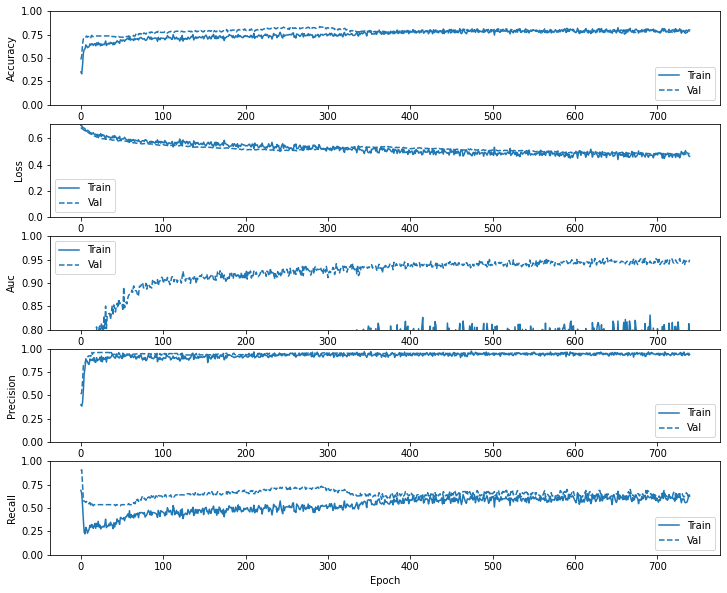

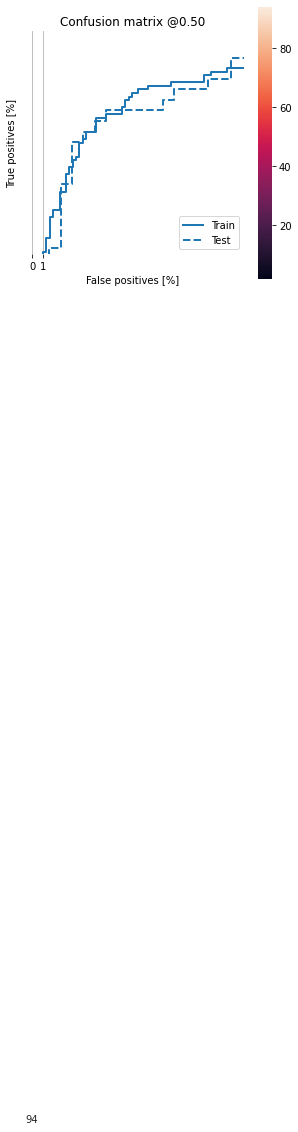

In [19]:
%%time
expId = 103
desc = str(expId) + " AngleEmbedding StronglyEntanglingLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))   
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, {"weights": (n_layers, n_qubits, 3)}, output_dim=n_qubits)

model_103, history_103 = runTheExperiments(expId, desc)

## IQPEmbedding

Epoch 1/10000
13/13 [==============================] - 904s 70s/step - loss: 0.7029 - tp: 123.8571 - fp: 66.2143 - tn: 220.2857 - fn: 158.5000 - accuracy: 0.6233 - precision: 0.6731 - recall: 0.4632 - auc: 0.7229 - val_loss: 0.7109 - val_tp: 30.0000 - val_fp: 23.0000 - val_tn: 50.0000 - val_fn: 56.0000 - val_accuracy: 0.5031 - val_precision: 0.5660 - val_recall: 0.3488 - val_auc: 0.4213
Epoch 2/10000
13/13 [==============================] - 904s 70s/step - loss: 0.7049 - tp: 54.8571 - fp: 53.0714 - tn: 138.8571 - fn: 123.0714 - accuracy: 0.5343 - precision: 0.5125 - recall: 0.3170 - auc: 0.4927 - val_loss: 0.7114 - val_tp: 27.0000 - val_fp: 21.0000 - val_tn: 52.0000 - val_fn: 59.0000 - val_accuracy: 0.4969 - val_precision: 0.5625 - val_recall: 0.3140 - val_auc: 0.4236
Epoch 3/10000
13/13 [==============================] - 905s 70s/step - loss: 0.7126 - tp: 58.7857 - fp: 45.7857 - tn: 148.0000 - fn: 117.2857 - accuracy: 0.5765 - precision: 0.5728 - recall: 0.3487 - auc: 0.5136 - val_los

13/13 [==============================] - 905s 70s/step - loss: 0.6878 - tp: 53.2143 - fp: 17.0714 - tn: 170.5000 - fn: 129.0714 - accuracy: 0.6066 - precision: 0.7775 - recall: 0.2985 - auc: 0.5464 - val_loss: 0.7636 - val_tp: 3.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 83.0000 - val_accuracy: 0.4403 - val_precision: 0.3333 - val_recall: 0.0349 - val_auc: 0.2792
Epoch 23/10000
13/13 [==============================] - 905s 70s/step - loss: 0.6855 - tp: 42.7857 - fp: 18.8571 - tn: 169.5714 - fn: 138.6429 - accuracy: 0.5625 - precision: 0.6815 - recall: 0.2239 - auc: 0.5262 - val_loss: 0.7694 - val_tp: 3.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 83.0000 - val_accuracy: 0.4340 - val_precision: 0.3000 - val_recall: 0.0349 - val_auc: 0.2377
Epoch 24/10000
13/13 [==============================] - 906s 70s/step - loss: 0.6781 - tp: 52.2143 - fp: 13.0714 - tn: 180.6429 - fn: 123.9286 - accuracy: 0.6339 - precision: 0.8055 - recall: 0.3125 - auc: 0.5743 - val_loss: 0.7702 - val_t

Epoch 43/10000
13/13 [==============================] - 906s 70s/step - loss: 0.6745 - tp: 51.7857 - fp: 9.2143 - tn: 182.5714 - fn: 126.2857 - accuracy: 0.6326 - precision: 0.8578 - recall: 0.2810 - auc: 0.5775 - val_loss: 0.7871 - val_tp: 0.0000e+00 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 86.0000 - val_accuracy: 0.4403 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2033
Epoch 44/10000
13/13 [==============================] - 906s 70s/step - loss: 0.6817 - tp: 39.2857 - fp: 6.3571 - tn: 186.9286 - fn: 137.2857 - accuracy: 0.6131 - precision: 0.8309 - recall: 0.2093 - auc: 0.5296 - val_loss: 0.7892 - val_tp: 0.0000e+00 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 86.0000 - val_accuracy: 0.4403 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2215
Epoch 45/10000
13/13 [==============================] - 906s 70s/step - loss: 0.6833 - tp: 43.5000 - fp: 6.9286 - tn: 184.3571 - fn: 135.0714 - accuracy: 0.6075 - precision: 0.8454 - recall: 0.2320 - au

13/13 [==============================] - 906s 70s/step - loss: 0.6756 - tp: 44.7143 - fp: 7.7143 - tn: 186.7857 - fn: 130.6429 - accuracy: 0.6268 - precision: 0.8332 - recall: 0.2450 - auc: 0.5522 - val_loss: 0.8005 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 72.0000 - val_fn: 85.0000 - val_accuracy: 0.4591 - val_precision: 0.5000 - val_recall: 0.0116 - val_auc: 0.1554
Epoch 64/10000
13/13 [==============================] - 905s 70s/step - loss: 0.6699 - tp: 47.7857 - fp: 8.0000 - tn: 183.6429 - fn: 130.4286 - accuracy: 0.6153 - precision: 0.8655 - recall: 0.2496 - auc: 0.6093 - val_loss: 0.7990 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 73.0000 - val_fn: 86.0000 - val_accuracy: 0.4591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1790
Epoch 65/10000
13/13 [==============================] - 906s 70s/step - loss: 0.6694 - tp: 46.0714 - fp: 4.4286 - tn: 187.1429 - fn: 132.2143 - accuracy: 0.6276 - precision: 0.9067 - recall: 0.2504 - auc: 0.5696 - val_loss: 0

13/13 [==============================] - 907s 70s/step - loss: 0.6574 - tp: 55.9286 - fp: 5.7857 - tn: 181.5000 - fn: 126.6429 - accuracy: 0.6495 - precision: 0.9135 - recall: 0.3179 - auc: 0.6238 - val_loss: 0.8269 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 73.0000 - val_fn: 86.0000 - val_accuracy: 0.4591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1453
Epoch 84/10000
13/13 [==============================] - 907s 70s/step - loss: 0.6648 - tp: 47.7857 - fp: 5.2857 - tn: 187.7143 - fn: 129.0714 - accuracy: 0.6260 - precision: 0.8878 - recall: 0.2548 - auc: 0.5909 - val_loss: 0.8249 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 72.0000 - val_fn: 86.0000 - val_accuracy: 0.4528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1848
Epoch 85/10000
13/13 [==============================] - 906s 70s/step - loss: 0.6731 - tp: 44.5714 - fp: 7.0714 - tn: 186.5714 - fn: 131.6429 - accuracy: 0.6219 - precision: 0.8592 - recall: 0.2352 - auc: 0.5246 -

13/13 [==============================] - 906s 70s/step - loss: 0.6508 - tp: 45.0714 - fp: 6.0714 - tn: 187.0714 - fn: 131.6429 - accuracy: 0.6257 - precision: 0.8842 - recall: 0.2603 - auc: 0.6141 - val_loss: 0.8684 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 73.0000 - val_fn: 86.0000 - val_accuracy: 0.4591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1603
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
loss :  0.712977409362793
tp :  33.0
fp :  26.0
tn :  70.0
fn :  70.0
accuracy :  0.5175879597663879
precision :  0.5593220591545105
recall :  0.3203883469104767
auc :  0.4655643105506897

Legitimate Domain Name Detected (True Negatives):  71
Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives):  25
Botnet DGA Missed (False Negatives):  71
Botnet DGA Detected (True Positives):  32
Total Botnet DGAs:  103
CPU times: user 1d 1h 42min 16s, sys: 9min 56s, total: 1d 1h 52min 13s
Wall time: 1d 1h 58min 9s


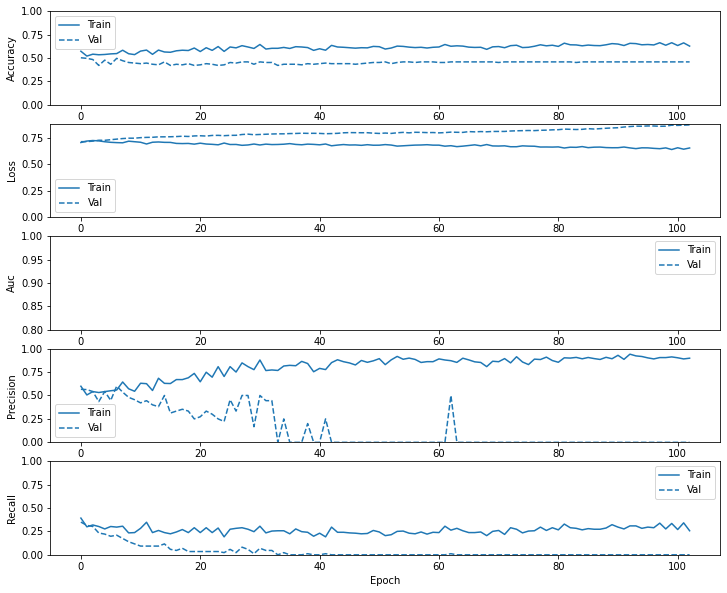

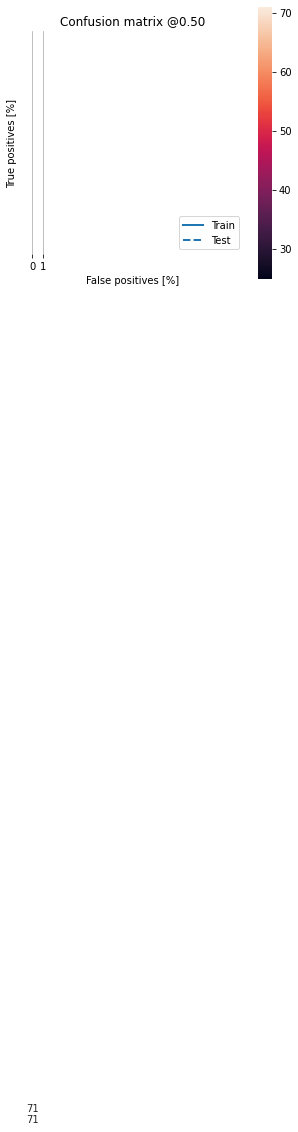

In [20]:
%%time
expId = 104
desc = str(expId) + " IQPEmbedding BasicEntanglerLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_104, history_104 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 890s 69s/step - loss: 0.7353 - tp: 73.7143 - fp: 78.1429 - tn: 208.3571 - fn: 208.6429 - accuracy: 0.5001 - precision: 0.4945 - recall: 0.2688 - auc: 0.4321 - val_loss: 0.7690 - val_tp: 2.0000 - val_fp: 21.0000 - val_tn: 52.0000 - val_fn: 84.0000 - val_accuracy: 0.3396 - val_precision: 0.0870 - val_recall: 0.0233 - val_auc: 0.1817
Epoch 2/10000
13/13 [==============================] - 889s 68s/step - loss: 0.7320 - tp: 47.3571 - fp: 54.7143 - tn: 137.2143 - fn: 130.5714 - accuracy: 0.5084 - precision: 0.4654 - recall: 0.2623 - auc: 0.4445 - val_loss: 0.7657 - val_tp: 6.0000 - val_fp: 21.0000 - val_tn: 52.0000 - val_fn: 80.0000 - val_accuracy: 0.3648 - val_precision: 0.2222 - val_recall: 0.0698 - val_auc: 0.1943
Epoch 3/10000
13/13 [==============================] - 889s 68s/step - loss: 0.7161 - tp: 52.6429 - fp: 45.8571 - tn: 147.9286 - fn: 123.4286 - accuracy: 0.5414 - precision: 0.5086 - recall: 0.2881 - auc: 0.4598 - val_loss: 

13/13 [==============================] - 891s 69s/step - loss: 0.6934 - tp: 53.4286 - fp: 63.7857 - tn: 123.7857 - fn: 128.8571 - accuracy: 0.4775 - precision: 0.4648 - recall: 0.2989 - auc: 0.4909 - val_loss: 0.7016 - val_tp: 18.0000 - val_fp: 20.0000 - val_tn: 53.0000 - val_fn: 68.0000 - val_accuracy: 0.4465 - val_precision: 0.4737 - val_recall: 0.2093 - val_auc: 0.4559
Epoch 23/10000
13/13 [==============================] - 891s 69s/step - loss: 0.7052 - tp: 49.9286 - fp: 57.5714 - tn: 130.8571 - fn: 131.5000 - accuracy: 0.4887 - precision: 0.4723 - recall: 0.2727 - auc: 0.4464 - val_loss: 0.6996 - val_tp: 15.0000 - val_fp: 18.0000 - val_tn: 55.0000 - val_fn: 71.0000 - val_accuracy: 0.4403 - val_precision: 0.4545 - val_recall: 0.1744 - val_auc: 0.4619
Epoch 24/10000
13/13 [==============================] - 891s 69s/step - loss: 0.6983 - tp: 49.3571 - fp: 53.1429 - tn: 140.5714 - fn: 126.7857 - accuracy: 0.5136 - precision: 0.4912 - recall: 0.2915 - auc: 0.4828 - val_loss: 0.6989 - v

13/13 [==============================] - 891s 69s/step - loss: 0.6833 - tp: 39.2143 - fp: 46.6429 - tn: 145.1429 - fn: 138.8571 - accuracy: 0.5059 - precision: 0.4709 - recall: 0.2143 - auc: 0.5412 - val_loss: 0.6853 - val_tp: 16.0000 - val_fp: 16.0000 - val_tn: 57.0000 - val_fn: 70.0000 - val_accuracy: 0.4591 - val_precision: 0.5000 - val_recall: 0.1860 - val_auc: 0.5448
Epoch 44/10000
13/13 [==============================] - 891s 69s/step - loss: 0.6828 - tp: 50.5714 - fp: 38.4286 - tn: 154.8571 - fn: 126.0000 - accuracy: 0.5734 - precision: 0.5830 - recall: 0.2983 - auc: 0.5995 - val_loss: 0.6829 - val_tp: 20.0000 - val_fp: 13.0000 - val_tn: 60.0000 - val_fn: 66.0000 - val_accuracy: 0.5031 - val_precision: 0.6061 - val_recall: 0.2326 - val_auc: 0.6092
Epoch 45/10000
13/13 [==============================] - 891s 69s/step - loss: 0.6803 - tp: 54.6429 - fp: 43.6429 - tn: 147.6429 - fn: 123.9286 - accuracy: 0.5572 - precision: 0.5781 - recall: 0.3207 - auc: 0.5889 - val_loss: 0.6843 - v

13/13 [==============================] - 891s 69s/step - loss: 0.6618 - tp: 68.5000 - fp: 41.0000 - tn: 150.6429 - fn: 109.7143 - accuracy: 0.5830 - precision: 0.6168 - recall: 0.3741 - auc: 0.6472 - val_loss: 0.6559 - val_tp: 25.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 61.0000 - val_accuracy: 0.5660 - val_precision: 0.7576 - val_recall: 0.2907 - val_auc: 0.7731
Epoch 65/10000
13/13 [==============================] - 890s 69s/step - loss: 0.6578 - tp: 64.5000 - fp: 38.9286 - tn: 152.6429 - fn: 113.7857 - accuracy: 0.5970 - precision: 0.6455 - recall: 0.3624 - auc: 0.6725 - val_loss: 0.6539 - val_tp: 34.0000 - val_fp: 12.0000 - val_tn: 61.0000 - val_fn: 52.0000 - val_accuracy: 0.5975 - val_precision: 0.7391 - val_recall: 0.3953 - val_auc: 0.7720
Epoch 66/10000
13/13 [==============================] - 891s 69s/step - loss: 0.6594 - tp: 67.0000 - fp: 51.8571 - tn: 140.7857 - fn: 110.2143 - accuracy: 0.5658 - precision: 0.5627 - recall: 0.3877 - auc: 0.6447 - val_loss: 0.6496 - va

13/13 [==============================] - 891s 69s/step - loss: 0.6251 - tp: 143.0714 - fp: 95.8571 - tn: 97.7857 - fn: 33.1429 - accuracy: 0.6410 - precision: 0.5857 - recall: 0.8137 - auc: 0.6747 - val_loss: 0.5953 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9225
Epoch 86/10000
13/13 [==============================] - 891s 69s/step - loss: 0.6082 - tp: 159.6429 - fp: 84.8571 - tn: 101.0714 - fn: 24.2857 - accuracy: 0.7164 - precision: 0.6646 - recall: 0.8805 - auc: 0.6960 - val_loss: 0.5946 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9211
Epoch 87/10000
13/13 [==============================] - 890s 69s/step - loss: 0.6114 - tp: 151.2857 - fp: 85.6429 - tn: 104.0000 - fn: 28.9286 - accuracy: 0.6892 - precision: 0.6388 - recall: 0.8387 - auc: 0.7167 - val_loss: 0.5910 - val_

13/13 [==============================] - 807s 62s/step - loss: 0.6011 - tp: 165.0714 - fp: 95.5000 - tn: 92.3571 - fn: 16.9286 - accuracy: 0.7025 - precision: 0.6449 - recall: 0.9060 - auc: 0.7109 - val_loss: 0.5661 - val_tp: 70.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 16.0000 - val_accuracy: 0.8805 - val_precision: 0.9589 - val_recall: 0.8140 - val_auc: 0.9306
Epoch 107/10000
13/13 [==============================] - 809s 62s/step - loss: 0.6031 - tp: 161.4286 - fp: 93.0000 - tn: 96.0000 - fn: 19.4286 - accuracy: 0.6915 - precision: 0.6303 - recall: 0.8793 - auc: 0.6992 - val_loss: 0.5613 - val_tp: 69.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 17.0000 - val_accuracy: 0.8742 - val_precision: 0.9583 - val_recall: 0.8023 - val_auc: 0.9414
Epoch 108/10000
13/13 [==============================] - 809s 62s/step - loss: 0.6105 - tp: 161.8571 - fp: 99.7143 - tn: 89.8571 - fn: 18.4286 - accuracy: 0.6710 - precision: 0.6080 - recall: 0.8981 - auc: 0.7303 - val_loss: 0.5678 - val_

13/13 [==============================] - 808s 62s/step - loss: 0.5938 - tp: 170.2857 - fp: 96.4286 - tn: 90.2857 - fn: 12.8571 - accuracy: 0.7083 - precision: 0.6471 - recall: 0.9349 - auc: 0.6836 - val_loss: 0.5455 - val_tp: 74.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 12.0000 - val_accuracy: 0.8994 - val_precision: 0.9487 - val_recall: 0.8605 - val_auc: 0.9376
Epoch 128/10000
13/13 [==============================] - 807s 62s/step - loss: 0.5921 - tp: 162.6429 - fp: 98.4286 - tn: 91.8571 - fn: 16.9286 - accuracy: 0.6922 - precision: 0.6294 - recall: 0.9107 - auc: 0.7017 - val_loss: 0.5486 - val_tp: 70.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 16.0000 - val_accuracy: 0.8805 - val_precision: 0.9589 - val_recall: 0.8140 - val_auc: 0.9413
Epoch 129/10000
13/13 [==============================] - 808s 62s/step - loss: 0.5837 - tp: 173.9286 - fp: 92.7143 - tn: 91.7857 - fn: 11.4286 - accuracy: 0.7215 - precision: 0.6615 - recall: 0.9401 - auc: 0.7158 - val_loss: 0.5499 - val_

13/13 [==============================] - 808s 62s/step - loss: 0.5946 - tp: 164.2143 - fp: 106.7143 - tn: 84.9286 - fn: 14.0000 - accuracy: 0.6673 - precision: 0.6010 - recall: 0.9257 - auc: 0.6962 - val_loss: 0.5292 - val_tp: 71.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 15.0000 - val_accuracy: 0.8805 - val_precision: 0.9467 - val_recall: 0.8256 - val_auc: 0.9513
Epoch 149/10000
13/13 [==============================] - 808s 62s/step - loss: 0.5866 - tp: 170.2857 - fp: 94.9286 - tn: 91.7143 - fn: 12.9286 - accuracy: 0.7001 - precision: 0.6400 - recall: 0.9249 - auc: 0.6944 - val_loss: 0.5256 - val_tp: 74.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 12.0000 - val_accuracy: 0.8994 - val_precision: 0.9487 - val_recall: 0.8605 - val_auc: 0.9504
Epoch 150/10000
13/13 [==============================] - 808s 62s/step - loss: 0.5985 - tp: 158.0714 - fp: 104.0000 - tn: 92.5714 - fn: 15.2143 - accuracy: 0.6687 - precision: 0.5946 - recall: 0.8968 - auc: 0.7105 - val_loss: 0.5268 - va

13/13 [==============================] - 808s 62s/step - loss: 0.5695 - tp: 165.5714 - fp: 95.0714 - tn: 95.9286 - fn: 13.2857 - accuracy: 0.7119 - precision: 0.6421 - recall: 0.9308 - auc: 0.7246 - val_loss: 0.5143 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9458
Epoch 170/10000
13/13 [==============================] - 807s 62s/step - loss: 0.5892 - tp: 161.2857 - fp: 102.3571 - tn: 92.0000 - fn: 14.2143 - accuracy: 0.6823 - precision: 0.6059 - recall: 0.9133 - auc: 0.6912 - val_loss: 0.5149 - val_tp: 74.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 12.0000 - val_accuracy: 0.8994 - val_precision: 0.9487 - val_recall: 0.8605 - val_auc: 0.9454
Epoch 171/10000
13/13 [==============================] - 808s 62s/step - loss: 0.5749 - tp: 165.0000 - fp: 101.0714 - tn: 93.4286 - fn: 10.3571 - accuracy: 0.7004 - precision: 0.6193 - recall: 0.9509 - auc: 0.6713 - val_loss: 0.5114 - va

13/13 [==============================] - 808s 62s/step - loss: 0.5747 - tp: 161.1429 - fp: 102.7143 - tn: 94.4286 - fn: 11.5714 - accuracy: 0.6926 - precision: 0.6104 - recall: 0.9321 - auc: 0.7105 - val_loss: 0.5067 - val_tp: 74.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 12.0000 - val_accuracy: 0.8994 - val_precision: 0.9487 - val_recall: 0.8605 - val_auc: 0.9458
Epoch 191/10000
13/13 [==============================] - 808s 62s/step - loss: 0.5775 - tp: 162.1429 - fp: 101.9286 - tn: 91.0714 - fn: 14.7143 - accuracy: 0.6864 - precision: 0.6144 - recall: 0.9163 - auc: 0.7090 - val_loss: 0.5022 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9531
Epoch 192/10000
13/13 [==============================] - 808s 62s/step - loss: 0.5694 - tp: 163.0714 - fp: 98.6429 - tn: 95.7143 - fn: 12.4286 - accuracy: 0.6939 - precision: 0.6148 - recall: 0.9305 - auc: 0.7249 - val_loss: 0.5016 - va

13/13 [==============================] - 808s 62s/step - loss: 0.5919 - tp: 162.2857 - fp: 104.0714 - tn: 87.0714 - fn: 16.4286 - accuracy: 0.6672 - precision: 0.6031 - recall: 0.9101 - auc: 0.6603 - val_loss: 0.4939 - val_tp: 75.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 11.0000 - val_accuracy: 0.8931 - val_precision: 0.9259 - val_recall: 0.8721 - val_auc: 0.9475
Epoch 212/10000
13/13 [==============================] - 809s 62s/step - loss: 0.5790 - tp: 163.9286 - fp: 102.9286 - tn: 90.5000 - fn: 12.5000 - accuracy: 0.6770 - precision: 0.6080 - recall: 0.9221 - auc: 0.6970 - val_loss: 0.4961 - val_tp: 74.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 12.0000 - val_accuracy: 0.8868 - val_precision: 0.9250 - val_recall: 0.8605 - val_auc: 0.9497
Epoch 213/10000
13/13 [==============================] - 808s 62s/step - loss: 0.5746 - tp: 170.4286 - fp: 104.9286 - tn: 86.3571 - fn: 8.1429 - accuracy: 0.6935 - precision: 0.6153 - recall: 0.9583 - auc: 0.6969 - val_loss: 0.4942 - va

13/13 [==============================] - 808s 62s/step - loss: 0.5644 - tp: 157.6429 - fp: 99.1429 - tn: 98.0714 - fn: 15.0000 - accuracy: 0.6911 - precision: 0.6130 - recall: 0.9133 - auc: 0.7094 - val_loss: 0.4867 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9555
Epoch 233/10000
13/13 [==============================] - 808s 62s/step - loss: 0.5782 - tp: 164.2143 - fp: 102.8571 - tn: 88.7857 - fn: 14.0000 - accuracy: 0.6814 - precision: 0.6081 - recall: 0.9281 - auc: 0.7155 - val_loss: 0.4830 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9494
Epoch 234/10000
13/13 [==============================] - 809s 62s/step - loss: 0.5878 - tp: 163.0714 - fp: 106.9286 - tn: 86.5714 - fn: 13.2857 - accuracy: 0.6635 - precision: 0.5870 - recall: 0.9267 - auc: 0.6918 - val_loss: 0.4964 - va

13/13 [==============================] - 808s 62s/step - loss: 0.5841 - tp: 161.5000 - fp: 108.1429 - tn: 85.6429 - fn: 14.5714 - accuracy: 0.6618 - precision: 0.5893 - recall: 0.9221 - auc: 0.7055 - val_loss: 0.4861 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9536
Epoch 254/10000
13/13 [==============================] - 807s 62s/step - loss: 0.5490 - tp: 166.7143 - fp: 90.2143 - tn: 99.7143 - fn: 13.2143 - accuracy: 0.7219 - precision: 0.6438 - recall: 0.9388 - auc: 0.7386 - val_loss: 0.4884 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9450
Epoch 255/10000
13/13 [==============================] - 809s 62s/step - loss: 0.5800 - tp: 163.6429 - fp: 100.2857 - tn: 89.2857 - fn: 16.6429 - accuracy: 0.6854 - precision: 0.6197 - recall: 0.9080 - auc: 0.7157 - val_loss: 0.4879 - va

13/13 [==============================] - 809s 62s/step - loss: 0.6030 - tp: 160.7857 - fp: 117.5714 - tn: 81.1429 - fn: 10.3571 - accuracy: 0.6315 - precision: 0.5460 - recall: 0.9331 - auc: 0.6890 - val_loss: 0.4785 - val_tp: 75.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 11.0000 - val_accuracy: 0.8931 - val_precision: 0.9259 - val_recall: 0.8721 - val_auc: 0.9415
Epoch 275/10000
13/13 [==============================] - 809s 62s/step - loss: 0.5389 - tp: 166.7857 - fp: 89.2143 - tn: 101.8571 - fn: 12.0000 - accuracy: 0.7214 - precision: 0.6489 - recall: 0.9288 - auc: 0.7678 - val_loss: 0.4761 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9449
Epoch 276/10000
13/13 [==============================] - 809s 62s/step - loss: 0.5877 - tp: 169.7143 - fp: 112.5000 - tn: 76.7143 - fn: 10.9286 - accuracy: 0.6754 - precision: 0.6089 - recall: 0.9480 - auc: 0.6741 - val_loss: 0.4764 - va

13/13 [==============================] - 807s 62s/step - loss: 0.5843 - tp: 168.9286 - fp: 106.9286 - tn: 82.2143 - fn: 11.7857 - accuracy: 0.6659 - precision: 0.6005 - recall: 0.9333 - auc: 0.7075 - val_loss: 0.4762 - val_tp: 78.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 8.0000 - val_accuracy: 0.9245 - val_precision: 0.9512 - val_recall: 0.9070 - val_auc: 0.9417
Epoch 296/10000
13/13 [==============================] - 810s 62s/step - loss: 0.5666 - tp: 168.2857 - fp: 96.5714 - tn: 94.7143 - fn: 10.2857 - accuracy: 0.7131 - precision: 0.6373 - recall: 0.9488 - auc: 0.7131 - val_loss: 0.4758 - val_tp: 77.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 9.0000 - val_accuracy: 0.8994 - val_precision: 0.9167 - val_recall: 0.8953 - val_auc: 0.9491
Epoch 297/10000
13/13 [==============================] - 808s 62s/step - loss: 0.5677 - tp: 160.3571 - fp: 101.9286 - tn: 90.6429 - fn: 16.9286 - accuracy: 0.6813 - precision: 0.6152 - recall: 0.9085 - auc: 0.7207 - val_loss: 0.4804 - val_

13/13 [==============================] - 809s 62s/step - loss: 0.5996 - tp: 170.7143 - fp: 116.2143 - tn: 74.2143 - fn: 8.7143 - accuracy: 0.6587 - precision: 0.5987 - recall: 0.9407 - auc: 0.6527 - val_loss: 0.4701 - val_tp: 77.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 9.0000 - val_accuracy: 0.8931 - val_precision: 0.9059 - val_recall: 0.8953 - val_auc: 0.9513
Epoch 317/10000
13/13 [==============================] - 807s 62s/step - loss: 0.5576 - tp: 166.2143 - fp: 102.9286 - tn: 90.8571 - fn: 9.8571 - accuracy: 0.6974 - precision: 0.6145 - recall: 0.9498 - auc: 0.7364 - val_loss: 0.4647 - val_tp: 77.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 9.0000 - val_accuracy: 0.8994 - val_precision: 0.9167 - val_recall: 0.8953 - val_auc: 0.9454
Epoch 318/10000
13/13 [==============================] - 808s 62s/step - loss: 0.5849 - tp: 160.0000 - fp: 103.5000 - tn: 91.2143 - fn: 15.1429 - accuracy: 0.6770 - precision: 0.6088 - recall: 0.9057 - auc: 0.6897 - val_loss: 0.4750 - val_t

13/13 [==============================] - 808s 62s/step - loss: 0.5596 - tp: 159.5714 - fp: 100.7857 - tn: 99.1429 - fn: 10.3571 - accuracy: 0.6939 - precision: 0.6052 - recall: 0.9286 - auc: 0.7161 - val_loss: 0.4721 - val_tp: 78.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 8.0000 - val_accuracy: 0.9057 - val_precision: 0.9176 - val_recall: 0.9070 - val_auc: 0.9429
Epoch 338/10000
13/13 [==============================] - 809s 62s/step - loss: 0.5541 - tp: 166.2143 - fp: 102.4286 - tn: 94.0000 - fn: 7.2143 - accuracy: 0.7040 - precision: 0.6132 - recall: 0.9639 - auc: 0.7155 - val_loss: 0.4690 - val_tp: 77.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 9.0000 - val_accuracy: 0.8931 - val_precision: 0.9059 - val_recall: 0.8953 - val_auc: 0.9377
Epoch 339/10000
13/13 [==============================] - 809s 62s/step - loss: 0.5688 - tp: 169.5714 - fp: 98.8571 - tn: 89.7857 - fn: 11.6429 - accuracy: 0.7029 - precision: 0.6381 - recall: 0.9363 - auc: 0.7131 - val_loss: 0.4691 - val_t

13/13 [==============================] - 809s 62s/step - loss: 0.5727 - tp: 169.3571 - fp: 102.7857 - tn: 88.2857 - fn: 9.4286 - accuracy: 0.6936 - precision: 0.6191 - recall: 0.9520 - auc: 0.6987 - val_loss: 0.4720 - val_tp: 78.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 8.0000 - val_accuracy: 0.9119 - val_precision: 0.9286 - val_recall: 0.9070 - val_auc: 0.9341
Epoch 359/10000
13/13 [==============================] - 809s 62s/step - loss: 0.5982 - tp: 169.8571 - fp: 110.7143 - tn: 76.7857 - fn: 12.5000 - accuracy: 0.6680 - precision: 0.6078 - recall: 0.9290 - auc: 0.6460 - val_loss: 0.4715 - val_tp: 77.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 9.0000 - val_accuracy: 0.8994 - val_precision: 0.9167 - val_recall: 0.8953 - val_auc: 0.9271
Epoch 360/10000
13/13 [==============================] - 808s 62s/step - loss: 0.5508 - tp: 172.1429 - fp: 93.1429 - tn: 95.8571 - fn: 8.7143 - accuracy: 0.7278 - precision: 0.6515 - recall: 0.9565 - auc: 0.7022 - val_loss: 0.4654 - val_tp

13/13 [==============================] - 808s 62s/step - loss: 0.5448 - tp: 166.5714 - fp: 92.5000 - tn: 99.6429 - fn: 11.1429 - accuracy: 0.7301 - precision: 0.6556 - recall: 0.9387 - auc: 0.7556 - val_loss: 0.4597 - val_tp: 79.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 7.0000 - val_accuracy: 0.9182 - val_precision: 0.9294 - val_recall: 0.9186 - val_auc: 0.9540
Epoch 380/10000
13/13 [==============================] - 808s 62s/step - loss: 0.5696 - tp: 167.1429 - fp: 103.7143 - tn: 90.8571 - fn: 8.1429 - accuracy: 0.6927 - precision: 0.6108 - recall: 0.9595 - auc: 0.6853 - val_loss: 0.4592 - val_tp: 77.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 9.0000 - val_accuracy: 0.8994 - val_precision: 0.9167 - val_recall: 0.8953 - val_auc: 0.9489
Epoch 381/10000
13/13 [==============================] - 809s 62s/step - loss: 0.5938 - tp: 160.1429 - fp: 100.1429 - tn: 94.0000 - fn: 15.5714 - accuracy: 0.6814 - precision: 0.6149 - recall: 0.8973 - auc: 0.7006 - val_loss: 0.4647 - val_t

13/13 [==============================] - 810s 62s/step - loss: 0.5662 - tp: 167.5000 - fp: 100.7857 - tn: 89.4286 - fn: 12.1429 - accuracy: 0.6981 - precision: 0.6339 - recall: 0.9309 - auc: 0.6927 - val_loss: 0.4744 - val_tp: 77.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 9.0000 - val_accuracy: 0.8994 - val_precision: 0.9167 - val_recall: 0.8953 - val_auc: 0.9309
Epoch 401/10000
13/13 [==============================] - 809s 62s/step - loss: 0.5543 - tp: 165.0714 - fp: 100.6429 - tn: 92.9286 - fn: 11.2143 - accuracy: 0.6957 - precision: 0.6203 - recall: 0.9366 - auc: 0.7415 - val_loss: 0.4696 - val_tp: 78.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 8.0000 - val_accuracy: 0.9057 - val_precision: 0.9176 - val_recall: 0.9070 - val_auc: 0.9376
Epoch 402/10000
13/13 [==============================] - 809s 62s/step - loss: 0.5430 - tp: 169.6429 - fp: 98.8571 - tn: 92.7143 - fn: 8.6429 - accuracy: 0.7156 - precision: 0.6378 - recall: 0.9594 - auc: 0.7201 - val_loss: 0.4668 - val_t

13/13 [==============================] - 810s 62s/step - loss: 0.5984 - tp: 161.8571 - fp: 110.6429 - tn: 84.2143 - fn: 13.1429 - accuracy: 0.6516 - precision: 0.5791 - recall: 0.9200 - auc: 0.6930 - val_loss: 0.4694 - val_tp: 79.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 7.0000 - val_accuracy: 0.8994 - val_precision: 0.8977 - val_recall: 0.9186 - val_auc: 0.9239
Epoch 422/10000
13/13 [==============================] - 808s 62s/step - loss: 0.5698 - tp: 169.6429 - fp: 106.5000 - tn: 85.5000 - fn: 8.2143 - accuracy: 0.6795 - precision: 0.6019 - recall: 0.9551 - auc: 0.6969 - val_loss: 0.4639 - val_tp: 78.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 8.0000 - val_accuracy: 0.8994 - val_precision: 0.9070 - val_recall: 0.9070 - val_auc: 0.9513
Epoch 423/10000
13/13 [==============================] - 809s 62s/step - loss: 0.5919 - tp: 173.0714 - fp: 103.7143 - tn: 79.9286 - fn: 13.1429 - accuracy: 0.6824 - precision: 0.6310 - recall: 0.9312 - auc: 0.6551 - val_loss: 0.4634 - val_

13/13 [==============================] - 808s 62s/step - loss: 0.5703 - tp: 170.6429 - fp: 103.0000 - tn: 86.0714 - fn: 10.1429 - accuracy: 0.6905 - precision: 0.6192 - recall: 0.9448 - auc: 0.6934 - val_loss: 0.4673 - val_tp: 78.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 8.0000 - val_accuracy: 0.8931 - val_precision: 0.8966 - val_recall: 0.9070 - val_auc: 0.9419
Epoch 443/10000
13/13 [==============================] - 809s 62s/step - loss: 0.5846 - tp: 169.2143 - fp: 110.2143 - tn: 81.4286 - fn: 9.0000 - accuracy: 0.6718 - precision: 0.6044 - recall: 0.9500 - auc: 0.6725 - val_loss: 0.4634 - val_tp: 77.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 9.0000 - val_accuracy: 0.8868 - val_precision: 0.8953 - val_recall: 0.8953 - val_auc: 0.9396
Epoch 444/10000
13/13 [==============================] - 809s 62s/step - loss: 0.5650 - tp: 160.5714 - fp: 102.5000 - tn: 93.0714 - fn: 13.7143 - accuracy: 0.6832 - precision: 0.6073 - recall: 0.9105 - auc: 0.7326 - val_loss: 0.4625 - val_

13/13 [==============================] - 808s 62s/step - loss: 0.5819 - tp: 168.8571 - fp: 114.3571 - tn: 77.9286 - fn: 8.7143 - accuracy: 0.6669 - precision: 0.5974 - recall: 0.9457 - auc: 0.6868 - val_loss: 0.4600 - val_tp: 78.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 8.0000 - val_accuracy: 0.8931 - val_precision: 0.8966 - val_recall: 0.9070 - val_auc: 0.9409
Epoch 464/10000
13/13 [==============================] - 809s 62s/step - loss: 0.5727 - tp: 170.5714 - fp: 101.1429 - tn: 87.4286 - fn: 10.7143 - accuracy: 0.7026 - precision: 0.6314 - recall: 0.9456 - auc: 0.7105 - val_loss: 0.4540 - val_tp: 77.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 9.0000 - val_accuracy: 0.8994 - val_precision: 0.9167 - val_recall: 0.8953 - val_auc: 0.9435
Epoch 465/10000
13/13 [==============================] - 809s 62s/step - loss: 0.5727 - tp: 164.7143 - fp: 107.2857 - tn: 86.2857 - fn: 11.5714 - accuracy: 0.6799 - precision: 0.6014 - recall: 0.9392 - auc: 0.6970 - val_loss: 0.4574 - val_

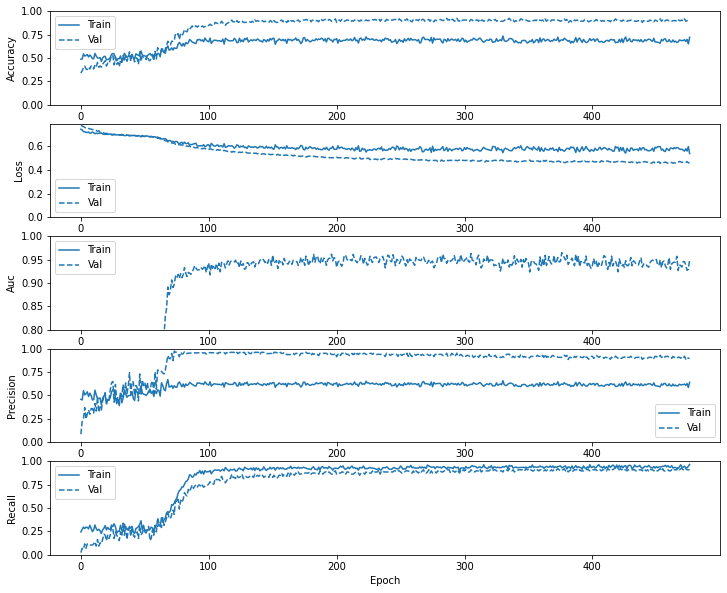

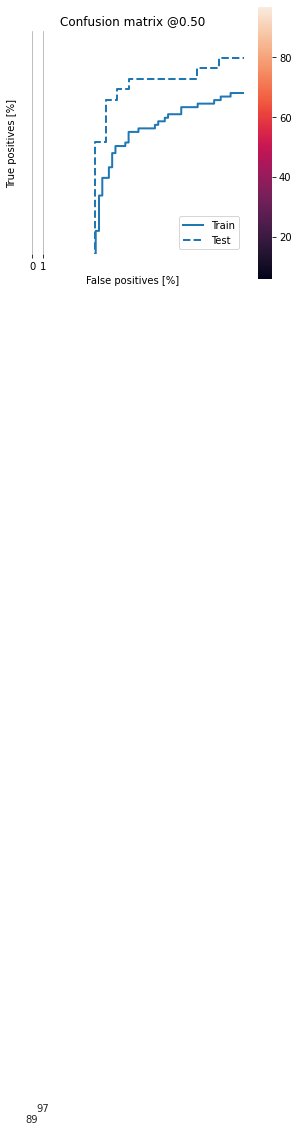

In [21]:
%%time
expId = 105
desc = str(expId) + " IQPEmbedding RandomLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.RandomLayers(weights, wires=range(n_qubits))   
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_105, history_105 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 1568s 121s/step - loss: 0.7265 - tp: 258.2143 - fp: 192.4286 - tn: 94.0714 - fn: 24.1429 - accuracy: 0.6462 - precision: 0.5997 - recall: 0.9183 - auc: 0.6805 - val_loss: 0.7250 - val_tp: 69.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 17.0000 - val_accuracy: 0.4340 - val_precision: 0.4859 - val_recall: 0.8023 - val_auc: 0.3145
Epoch 2/10000
13/13 [==============================] - 1566s 120s/step - loss: 0.7355 - tp: 153.6429 - fp: 191.4286 - tn: 0.5000 - fn: 24.2857 - accuracy: 0.4126 - precision: 0.4391 - recall: 0.8710 - auc: 0.4360 - val_loss: 0.7202 - val_tp: 69.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 17.0000 - val_accuracy: 0.4340 - val_precision: 0.4859 - val_recall: 0.8023 - val_auc: 0.3452
Epoch 3/10000
13/13 [==============================] - 1567s 121s/step - loss: 0.7409 - tp: 148.2857 - fp: 193.3571 - tn: 0.4286 - fn: 27.7857 - accuracy: 0.3935 - precision: 0.4235 - recall: 0.8469 - auc: 0.3949 

Epoch 22/10000
13/13 [==============================] - 1567s 121s/step - loss: 0.6984 - tp: 83.5714 - fp: 78.6429 - tn: 108.9286 - fn: 98.7143 - accuracy: 0.5203 - precision: 0.5231 - recall: 0.4617 - auc: 0.5137 - val_loss: 0.7108 - val_tp: 28.0000 - val_fp: 30.0000 - val_tn: 43.0000 - val_fn: 58.0000 - val_accuracy: 0.4465 - val_precision: 0.4828 - val_recall: 0.3256 - val_auc: 0.3495
Epoch 23/10000
13/13 [==============================] - 1566s 120s/step - loss: 0.6917 - tp: 80.0000 - fp: 73.6429 - tn: 114.7857 - fn: 101.4286 - accuracy: 0.5474 - precision: 0.5500 - recall: 0.4657 - auc: 0.5600 - val_loss: 0.7141 - val_tp: 20.0000 - val_fp: 33.0000 - val_tn: 40.0000 - val_fn: 66.0000 - val_accuracy: 0.3774 - val_precision: 0.3774 - val_recall: 0.2326 - val_auc: 0.3163
Epoch 24/10000
13/13 [==============================] - 1565s 120s/step - loss: 0.6972 - tp: 70.7857 - fp: 58.5000 - tn: 135.2143 - fn: 105.3571 - accuracy: 0.5465 - precision: 0.5404 - recall: 0.4113 - auc: 0.5083 - 

Epoch 43/10000
13/13 [==============================] - 1570s 121s/step - loss: 0.6833 - tp: 46.5714 - fp: 3.7143 - tn: 188.0714 - fn: 131.5000 - accuracy: 0.6442 - precision: 0.9263 - recall: 0.2797 - auc: 0.6178 - val_loss: 0.7120 - val_tp: 12.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 74.0000 - val_accuracy: 0.4969 - val_precision: 0.6667 - val_recall: 0.1395 - val_auc: 0.3441
Epoch 44/10000
13/13 [==============================] - 1571s 121s/step - loss: 0.6846 - tp: 50.2143 - fp: 5.0000 - tn: 188.2857 - fn: 126.3571 - accuracy: 0.6734 - precision: 0.9195 - recall: 0.3327 - auc: 0.5857 - val_loss: 0.7111 - val_tp: 11.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 75.0000 - val_accuracy: 0.5094 - val_precision: 0.7857 - val_recall: 0.1279 - val_auc: 0.3643
Epoch 45/10000
13/13 [==============================] - 1567s 121s/step - loss: 0.6941 - tp: 38.0000 - fp: 4.6429 - tn: 186.6429 - fn: 140.5714 - accuracy: 0.6009 - precision: 0.8728 - recall: 0.2077 - auc: 0.5481 - val_

13/13 [==============================] - 1568s 121s/step - loss: 0.6894 - tp: 43.9286 - fp: 6.0714 - tn: 185.5714 - fn: 134.2857 - accuracy: 0.6254 - precision: 0.8902 - recall: 0.2599 - auc: 0.5018 - val_loss: 0.7093 - val_tp: 12.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 74.0000 - val_accuracy: 0.5157 - val_precision: 0.8000 - val_recall: 0.1395 - val_auc: 0.3515
Epoch 65/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.6879 - tp: 44.7857 - fp: 5.2857 - tn: 186.2857 - fn: 133.5000 - accuracy: 0.6254 - precision: 0.8886 - recall: 0.2527 - auc: 0.5296 - val_loss: 0.7085 - val_tp: 14.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 72.0000 - val_accuracy: 0.5283 - val_precision: 0.8235 - val_recall: 0.1628 - val_auc: 0.3728
Epoch 66/10000
13/13 [==============================] - 1571s 121s/step - loss: 0.6842 - tp: 47.5000 - fp: 5.3571 - tn: 187.2857 - fn: 129.7143 - accuracy: 0.6424 - precision: 0.9071 - recall: 0.2760 - auc: 0.5954 - val_loss: 0.7092 - 

13/13 [==============================] - 1570s 121s/step - loss: 0.6601 - tp: 58.8571 - fp: 1.8571 - tn: 191.7857 - fn: 117.3571 - accuracy: 0.6888 - precision: 0.9756 - recall: 0.3481 - auc: 0.6410 - val_loss: 0.7144 - val_tp: 15.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 71.0000 - val_accuracy: 0.5346 - val_precision: 0.8333 - val_recall: 0.1744 - val_auc: 0.3734
Epoch 86/10000
13/13 [==============================] - 1570s 121s/step - loss: 0.6638 - tp: 58.5714 - fp: 3.5714 - tn: 182.3571 - fn: 125.3571 - accuracy: 0.6505 - precision: 0.9579 - recall: 0.3200 - auc: 0.6461 - val_loss: 0.7184 - val_tp: 17.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 69.0000 - val_accuracy: 0.5409 - val_precision: 0.8095 - val_recall: 0.1977 - val_auc: 0.3367
Epoch 87/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.6722 - tp: 45.6429 - fp: 4.2143 - tn: 185.4286 - fn: 134.5714 - accuracy: 0.6216 - precision: 0.9065 - recall: 0.2502 - auc: 0.5766 - val_loss: 0.7155 - 

13/13 [==============================] - 1570s 121s/step - loss: 0.6379 - tp: 58.7857 - fp: 2.7857 - tn: 185.0714 - fn: 123.2143 - accuracy: 0.6572 - precision: 0.9556 - recall: 0.3309 - auc: 0.6997 - val_loss: 0.7478 - val_tp: 16.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 70.0000 - val_accuracy: 0.5346 - val_precision: 0.8000 - val_recall: 0.1860 - val_auc: 0.4129
Epoch 107/10000
13/13 [==============================] - 1568s 121s/step - loss: 0.6327 - tp: 58.0000 - fp: 2.9286 - tn: 186.0714 - fn: 122.8571 - accuracy: 0.6660 - precision: 0.9592 - recall: 0.3279 - auc: 0.6587 - val_loss: 0.7502 - val_tp: 16.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 70.0000 - val_accuracy: 0.5409 - val_precision: 0.8421 - val_recall: 0.1860 - val_auc: 0.3718
Epoch 108/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.6401 - tp: 55.4286 - fp: 4.7857 - tn: 184.7857 - fn: 124.8571 - accuracy: 0.6595 - precision: 0.9219 - recall: 0.3236 - auc: 0.6808 - val_loss: 0.7532 

Epoch 127/10000
13/13 [==============================] - 1571s 121s/step - loss: 0.5909 - tp: 67.7857 - fp: 4.6429 - tn: 182.0714 - fn: 115.3571 - accuracy: 0.6772 - precision: 0.9429 - recall: 0.3854 - auc: 0.7032 - val_loss: 0.7977 - val_tp: 14.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 72.0000 - val_accuracy: 0.5283 - val_precision: 0.8235 - val_recall: 0.1628 - val_auc: 0.3568
Epoch 128/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.6047 - tp: 65.4286 - fp: 6.6429 - tn: 183.6429 - fn: 114.1429 - accuracy: 0.6621 - precision: 0.8915 - recall: 0.3576 - auc: 0.6921 - val_loss: 0.7997 - val_tp: 15.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 71.0000 - val_accuracy: 0.5346 - val_precision: 0.8333 - val_recall: 0.1744 - val_auc: 0.3543
Epoch 129/10000
13/13 [==============================] - 1567s 121s/step - loss: 0.6052 - tp: 66.1429 - fp: 6.4286 - tn: 178.0714 - fn: 119.2143 - accuracy: 0.6526 - precision: 0.9303 - recall: 0.3536 - auc: 0.7128 - v

Epoch 148/10000
13/13 [==============================] - 1570s 121s/step - loss: 0.5902 - tp: 65.8571 - fp: 5.7857 - tn: 185.8571 - fn: 112.3571 - accuracy: 0.6703 - precision: 0.9029 - recall: 0.3543 - auc: 0.7540 - val_loss: 0.7787 - val_tp: 18.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 68.0000 - val_accuracy: 0.5535 - val_precision: 0.8571 - val_recall: 0.2093 - val_auc: 0.4767
Epoch 149/10000
13/13 [==============================] - 1570s 121s/step - loss: 0.6009 - tp: 70.0000 - fp: 4.7857 - tn: 181.8571 - fn: 113.2143 - accuracy: 0.6730 - precision: 0.9308 - recall: 0.3793 - auc: 0.7017 - val_loss: 0.7820 - val_tp: 19.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 67.0000 - val_accuracy: 0.5597 - val_precision: 0.8636 - val_recall: 0.2209 - val_auc: 0.4681
Epoch 150/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.5797 - tp: 61.2143 - fp: 6.2857 - tn: 190.2857 - fn: 112.0714 - accuracy: 0.6874 - precision: 0.9170 - recall: 0.3587 - auc: 0.7204 - v

Epoch 169/10000
13/13 [==============================] - 1568s 121s/step - loss: 0.5952 - tp: 69.9286 - fp: 8.0714 - tn: 182.9286 - fn: 108.9286 - accuracy: 0.6778 - precision: 0.9117 - recall: 0.3805 - auc: 0.7470 - val_loss: 0.7103 - val_tp: 21.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 65.0000 - val_accuracy: 0.5723 - val_precision: 0.8750 - val_recall: 0.2442 - val_auc: 0.6418
Epoch 170/10000
13/13 [==============================] - 1565s 120s/step - loss: 0.5908 - tp: 66.8571 - fp: 7.2857 - tn: 187.0714 - fn: 108.6429 - accuracy: 0.6815 - precision: 0.8886 - recall: 0.3612 - auc: 0.7387 - val_loss: 0.7009 - val_tp: 19.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 67.0000 - val_accuracy: 0.5597 - val_precision: 0.8636 - val_recall: 0.2209 - val_auc: 0.7025
Epoch 171/10000
13/13 [==============================] - 1566s 120s/step - loss: 0.5636 - tp: 73.5000 - fp: 5.2143 - tn: 189.2857 - fn: 101.8571 - accuracy: 0.7225 - precision: 0.9442 - recall: 0.4375 - auc: 0.7776 - v

Epoch 190/10000
13/13 [==============================] - 1567s 121s/step - loss: 0.5695 - tp: 74.8571 - fp: 10.4286 - tn: 186.7143 - fn: 97.8571 - accuracy: 0.7055 - precision: 0.8759 - recall: 0.4254 - auc: 0.7647 - val_loss: 0.6479 - val_tp: 35.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 51.0000 - val_accuracy: 0.6604 - val_precision: 0.9211 - val_recall: 0.4070 - val_auc: 0.7815
Epoch 191/10000
13/13 [==============================] - 1568s 121s/step - loss: 0.5414 - tp: 88.7857 - fp: 7.5000 - tn: 185.5000 - fn: 88.0714 - accuracy: 0.7502 - precision: 0.9200 - recall: 0.5218 - auc: 0.7902 - val_loss: 0.6421 - val_tp: 33.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 53.0000 - val_accuracy: 0.6541 - val_precision: 0.9429 - val_recall: 0.3837 - val_auc: 0.8035
Epoch 192/10000
13/13 [==============================] - 1568s 121s/step - loss: 0.5264 - tp: 90.2143 - fp: 5.1429 - tn: 189.2143 - fn: 85.2857 - accuracy: 0.7590 - precision: 0.9562 - recall: 0.5099 - auc: 0.8014 - val

13/13 [==============================] - 1569s 121s/step - loss: 0.5490 - tp: 92.7857 - fp: 5.3571 - tn: 185.7857 - fn: 85.9286 - accuracy: 0.7434 - precision: 0.9426 - recall: 0.4991 - auc: 0.7750 - val_loss: 0.5929 - val_tp: 52.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 34.0000 - val_accuracy: 0.7673 - val_precision: 0.9455 - val_recall: 0.6047 - val_auc: 0.8883
Epoch 212/10000
13/13 [==============================] - 1568s 121s/step - loss: 0.5542 - tp: 91.4286 - fp: 9.7857 - tn: 183.6429 - fn: 85.0000 - accuracy: 0.7441 - precision: 0.9025 - recall: 0.5239 - auc: 0.7568 - val_loss: 0.5916 - val_tp: 49.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 37.0000 - val_accuracy: 0.7484 - val_precision: 0.9423 - val_recall: 0.5698 - val_auc: 0.8729
Epoch 213/10000
13/13 [==============================] - 1567s 120s/step - loss: 0.5589 - tp: 95.2857 - fp: 7.2143 - tn: 184.0714 - fn: 83.2857 - accuracy: 0.7514 - precision: 0.9337 - recall: 0.5169 - auc: 0.7446 - val_loss: 0.5913 - v

13/13 [==============================] - 1568s 121s/step - loss: 0.5327 - tp: 95.5000 - fp: 7.9286 - tn: 189.2857 - fn: 77.1429 - accuracy: 0.7807 - precision: 0.9315 - recall: 0.5686 - auc: 0.7870 - val_loss: 0.5449 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9342
Epoch 233/10000
13/13 [==============================] - 1568s 121s/step - loss: 0.5611 - tp: 85.2143 - fp: 7.6429 - tn: 184.0000 - fn: 93.0000 - accuracy: 0.7303 - precision: 0.9198 - recall: 0.4736 - auc: 0.7489 - val_loss: 0.5525 - val_tp: 52.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 34.0000 - val_accuracy: 0.7673 - val_precision: 0.9455 - val_recall: 0.6047 - val_auc: 0.9301
Epoch 234/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.5325 - tp: 98.9286 - fp: 6.9286 - tn: 186.5714 - fn: 77.4286 - accuracy: 0.7755 - precision: 0.9277 - recall: 0.5587 - auc: 0.7720 - val_loss: 0.5555 - v

13/13 [==============================] - 1567s 120s/step - loss: 0.5233 - tp: 99.7857 - fp: 4.5000 - tn: 189.2857 - fn: 76.2857 - accuracy: 0.7816 - precision: 0.9468 - recall: 0.5671 - auc: 0.7834 - val_loss: 0.5307 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9302
Epoch 254/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.5003 - tp: 105.3571 - fp: 5.0000 - tn: 184.9286 - fn: 74.5714 - accuracy: 0.7936 - precision: 0.9607 - recall: 0.5939 - auc: 0.7873 - val_loss: 0.5359 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9282
Epoch 255/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.4980 - tp: 109.0000 - fp: 5.4286 - tn: 184.1429 - fn: 71.2857 - accuracy: 0.7976 - precision: 0.9588 - recall: 0.6096 - auc: 0.8041 - val_loss: 0.5259 -

13/13 [==============================] - 1568s 121s/step - loss: 0.4887 - tp: 101.2857 - fp: 8.4286 - tn: 190.2857 - fn: 69.8571 - accuracy: 0.8041 - precision: 0.9060 - recall: 0.6248 - auc: 0.8117 - val_loss: 0.5246 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9328
Epoch 275/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.5004 - tp: 108.3571 - fp: 4.6429 - tn: 186.4286 - fn: 70.4286 - accuracy: 0.8039 - precision: 0.9636 - recall: 0.6187 - auc: 0.7962 - val_loss: 0.5234 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9288
Epoch 276/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.5321 - tp: 103.5000 - fp: 5.5000 - tn: 183.7143 - fn: 77.1429 - accuracy: 0.7696 - precision: 0.9506 - recall: 0.5604 - auc: 0.7797 - val_loss: 0.5244 

13/13 [==============================] - 1571s 121s/step - loss: 0.5006 - tp: 111.2143 - fp: 9.9286 - tn: 179.2143 - fn: 69.5000 - accuracy: 0.7896 - precision: 0.9133 - recall: 0.6263 - auc: 0.8020 - val_loss: 0.5062 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9406
Epoch 296/10000
13/13 [==============================] - 1568s 121s/step - loss: 0.4944 - tp: 112.0000 - fp: 7.9286 - tn: 183.3571 - fn: 66.5714 - accuracy: 0.7950 - precision: 0.9293 - recall: 0.6258 - auc: 0.7890 - val_loss: 0.5080 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9424
Epoch 297/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.4920 - tp: 106.6429 - fp: 6.6429 - tn: 185.9286 - fn: 70.6429 - accuracy: 0.7909 - precision: 0.9448 - recall: 0.6018 - auc: 0.8107 - val_loss: 0.5042 

13/13 [==============================] - 1570s 121s/step - loss: 0.4974 - tp: 109.1429 - fp: 6.7143 - tn: 183.7143 - fn: 70.2857 - accuracy: 0.7762 - precision: 0.9336 - recall: 0.5917 - auc: 0.7957 - val_loss: 0.4978 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9389
Epoch 317/10000
13/13 [==============================] - 1570s 121s/step - loss: 0.4701 - tp: 111.9286 - fp: 2.4286 - tn: 191.3571 - fn: 64.1429 - accuracy: 0.8277 - precision: 0.9851 - recall: 0.6424 - auc: 0.8406 - val_loss: 0.4985 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9416
Epoch 318/10000
13/13 [==============================] - 1572s 121s/step - loss: 0.4942 - tp: 104.3571 - fp: 5.8571 - tn: 188.8571 - fn: 70.7857 - accuracy: 0.7929 - precision: 0.9520 - recall: 0.5966 - auc: 0.8197 - val_loss: 0.4959 

13/13 [==============================] - 1570s 121s/step - loss: 0.5104 - tp: 95.8571 - fp: 7.7857 - tn: 192.1429 - fn: 74.0714 - accuracy: 0.7739 - precision: 0.9136 - recall: 0.5514 - auc: 0.7947 - val_loss: 0.4949 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9421
Epoch 338/10000
13/13 [==============================] - 1570s 120s/step - loss: 0.5110 - tp: 98.2143 - fp: 7.5714 - tn: 188.8571 - fn: 75.2143 - accuracy: 0.7807 - precision: 0.9321 - recall: 0.5642 - auc: 0.7649 - val_loss: 0.4955 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9407
Epoch 339/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.5025 - tp: 112.5714 - fp: 6.2143 - tn: 182.4286 - fn: 68.6429 - accuracy: 0.7883 - precision: 0.9528 - recall: 0.6112 - auc: 0.7982 - val_loss: 0.4974 - 

13/13 [==============================] - 1568s 121s/step - loss: 0.5061 - tp: 101.5714 - fp: 6.2143 - tn: 184.8571 - fn: 77.2143 - accuracy: 0.7766 - precision: 0.9530 - recall: 0.5659 - auc: 0.7558 - val_loss: 0.4852 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9474
Epoch 359/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.4851 - tp: 110.5000 - fp: 5.9286 - tn: 181.5714 - fn: 71.8571 - accuracy: 0.7881 - precision: 0.9540 - recall: 0.6014 - auc: 0.7922 - val_loss: 0.4854 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9372
Epoch 360/10000
13/13 [==============================] - 1571s 121s/step - loss: 0.5345 - tp: 100.7143 - fp: 8.6429 - tn: 180.3571 - fn: 80.1429 - accuracy: 0.7565 - precision: 0.9170 - recall: 0.5526 - auc: 0.7447 - val_loss: 0.4880 

Epoch 379/10000
13/13 [==============================] - 1568s 121s/step - loss: 0.4838 - tp: 108.2143 - fp: 4.5000 - tn: 187.6429 - fn: 69.5000 - accuracy: 0.8017 - precision: 0.9620 - recall: 0.6162 - auc: 0.7876 - val_loss: 0.4836 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9420
Epoch 380/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.5098 - tp: 98.8571 - fp: 9.0714 - tn: 185.5000 - fn: 76.4286 - accuracy: 0.7668 - precision: 0.9067 - recall: 0.5619 - auc: 0.7729 - val_loss: 0.4822 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9469
Epoch 381/10000
13/13 [==============================] - 1570s 121s/step - loss: 0.4635 - tp: 110.9286 - fp: 5.5714 - tn: 188.5714 - fn: 64.7857 - accuracy: 0.8128 - precision: 0.9510 - recall: 0.6418 - auc: 0.8158 - va

Epoch 400/10000
13/13 [==============================] - 1571s 121s/step - loss: 0.5033 - tp: 105.6429 - fp: 8.2143 - tn: 182.0000 - fn: 74.0000 - accuracy: 0.7650 - precision: 0.9262 - recall: 0.5753 - auc: 0.7716 - val_loss: 0.4771 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9420
Epoch 401/10000
13/13 [==============================] - 1572s 121s/step - loss: 0.4668 - tp: 106.1429 - fp: 6.3571 - tn: 187.2143 - fn: 70.1429 - accuracy: 0.8008 - precision: 0.9504 - recall: 0.6145 - auc: 0.8076 - val_loss: 0.4742 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9459
Epoch 402/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.5089 - tp: 107.3571 - fp: 6.7857 - tn: 184.7857 - fn: 70.9286 - accuracy: 0.7790 - precision: 0.9367 - recall: 0.5858 - auc: 0.7720 - v

Epoch 421/10000
13/13 [==============================] - 1571s 121s/step - loss: 0.4678 - tp: 105.2857 - fp: 5.3571 - tn: 189.5000 - fn: 69.7143 - accuracy: 0.8023 - precision: 0.9512 - recall: 0.6065 - auc: 0.8147 - val_loss: 0.4705 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9419
Epoch 422/10000
13/13 [==============================] - 1571s 121s/step - loss: 0.4872 - tp: 111.5000 - fp: 8.5714 - tn: 183.4286 - fn: 66.3571 - accuracy: 0.7888 - precision: 0.9069 - recall: 0.6147 - auc: 0.8090 - val_loss: 0.4709 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9426
Epoch 423/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.5336 - tp: 97.6429 - fp: 7.6429 - tn: 176.0000 - fn: 88.5714 - accuracy: 0.7248 - precision: 0.9209 - recall: 0.5155 - auc: 0.8002 - va

Epoch 442/10000
13/13 [==============================] - 1572s 121s/step - loss: 0.5084 - tp: 101.1429 - fp: 6.9286 - tn: 182.1429 - fn: 79.6429 - accuracy: 0.7637 - precision: 0.9340 - recall: 0.5526 - auc: 0.7646 - val_loss: 0.4702 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9459
Epoch 443/10000
13/13 [==============================] - 1570s 121s/step - loss: 0.4796 - tp: 112.3571 - fp: 11.0000 - tn: 180.6429 - fn: 65.8571 - accuracy: 0.7871 - precision: 0.9034 - recall: 0.6320 - auc: 0.8037 - val_loss: 0.4645 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9464
Epoch 444/10000
13/13 [==============================] - 1572s 121s/step - loss: 0.4815 - tp: 105.7857 - fp: 8.4286 - tn: 187.1429 - fn: 68.5000 - accuracy: 0.8012 - precision: 0.9259 - recall: 0.6250 - auc: 0.7680 - 

Epoch 463/10000
13/13 [==============================] - 1570s 121s/step - loss: 0.4853 - tp: 99.2143 - fp: 4.4286 - tn: 187.8571 - fn: 78.3571 - accuracy: 0.7807 - precision: 0.9637 - recall: 0.5654 - auc: 0.7920 - val_loss: 0.4574 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9505
Epoch 464/10000
13/13 [==============================] - 1570s 121s/step - loss: 0.4824 - tp: 107.7857 - fp: 8.6429 - tn: 179.9286 - fn: 73.5000 - accuracy: 0.7786 - precision: 0.9265 - recall: 0.5961 - auc: 0.8065 - val_loss: 0.4622 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9437
Epoch 465/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.4382 - tp: 119.3571 - fp: 7.4286 - tn: 186.1429 - fn: 56.9286 - accuracy: 0.8297 - precision: 0.9398 - recall: 0.6800 - auc: 0.8351 - va

Epoch 484/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.4956 - tp: 112.9286 - fp: 6.5000 - tn: 173.0714 - fn: 77.3571 - accuracy: 0.7695 - precision: 0.9469 - recall: 0.5944 - auc: 0.8013 - val_loss: 0.4572 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9527
Epoch 485/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.4845 - tp: 110.3571 - fp: 6.9286 - tn: 183.5000 - fn: 69.0714 - accuracy: 0.7857 - precision: 0.9340 - recall: 0.5948 - auc: 0.7936 - val_loss: 0.4599 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9361
Epoch 486/10000
13/13 [==============================] - 1572s 121s/step - loss: 0.4750 - tp: 107.8571 - fp: 7.5000 - tn: 188.1429 - fn: 66.3571 - accuracy: 0.7935 - precision: 0.9254 - recall: 0.6157 - auc: 0.7810 - v

Epoch 505/10000
13/13 [==============================] - 1571s 121s/step - loss: 0.4991 - tp: 111.7857 - fp: 6.7143 - tn: 176.9286 - fn: 74.4286 - accuracy: 0.7625 - precision: 0.9324 - recall: 0.5897 - auc: 0.7503 - val_loss: 0.4607 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9469
Epoch 506/10000
13/13 [==============================] - 1568s 121s/step - loss: 0.4748 - tp: 112.1429 - fp: 5.2857 - tn: 185.0000 - fn: 67.4286 - accuracy: 0.8009 - precision: 0.9501 - recall: 0.6100 - auc: 0.8115 - val_loss: 0.4596 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9440
Epoch 507/10000
13/13 [==============================] - 1570s 121s/step - loss: 0.4737 - tp: 107.6429 - fp: 6.7143 - tn: 186.7857 - fn: 68.7143 - accuracy: 0.7931 - precision: 0.9369 - recall: 0.5971 - auc: 0.7996 - v

Epoch 526/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.4890 - tp: 104.1429 - fp: 7.7857 - tn: 184.4286 - fn: 73.5000 - accuracy: 0.7756 - precision: 0.9253 - recall: 0.5846 - auc: 0.7891 - val_loss: 0.4526 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9435
Epoch 527/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.4816 - tp: 108.5000 - fp: 6.5000 - tn: 185.3571 - fn: 69.5000 - accuracy: 0.7918 - precision: 0.9460 - recall: 0.5989 - auc: 0.7964 - val_loss: 0.4510 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9429
Epoch 528/10000
13/13 [==============================] - 1572s 121s/step - loss: 0.4539 - tp: 112.9286 - fp: 4.2857 - tn: 187.2857 - fn: 65.3571 - accuracy: 0.8157 - precision: 0.9678 - recall: 0.6429 - auc: 0.8255 - v

Epoch 547/10000
13/13 [==============================] - 1569s 121s/step - loss: 0.4603 - tp: 119.0714 - fp: 10.3571 - tn: 180.1429 - fn: 60.2857 - accuracy: 0.8074 - precision: 0.9159 - recall: 0.6693 - auc: 0.8214 - val_loss: 0.4510 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9505
Epoch 548/10000
13/13 [==============================] - 1568s 121s/step - loss: 0.4424 - tp: 112.0000 - fp: 6.6429 - tn: 187.6429 - fn: 63.5714 - accuracy: 0.8227 - precision: 0.9478 - recall: 0.6604 - auc: 0.8418 - val_loss: 0.4467 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9536
Epoch 549/10000
13/13 [==============================] - 1570s 121s/step - loss: 0.4906 - tp: 107.6429 - fp: 7.9286 - tn: 179.8571 - fn: 74.4286 - accuracy: 0.7705 - precision: 0.9317 - recall: 0.5716 - auc: 0.7968 - 

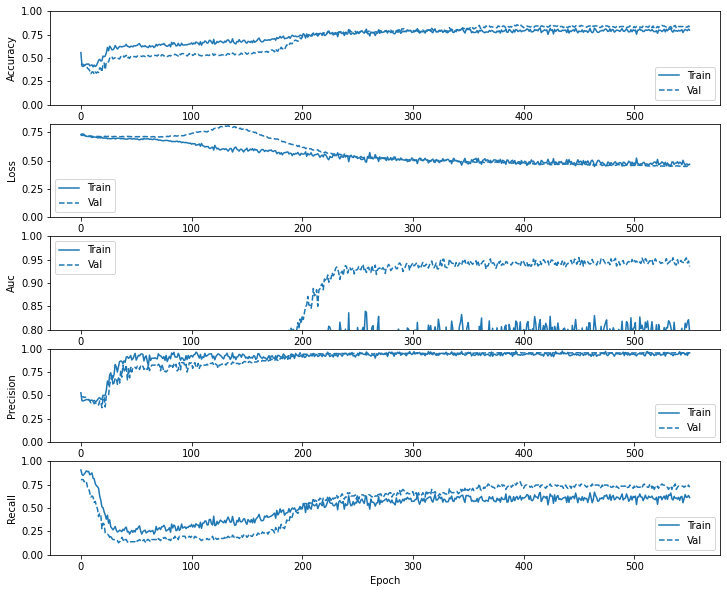

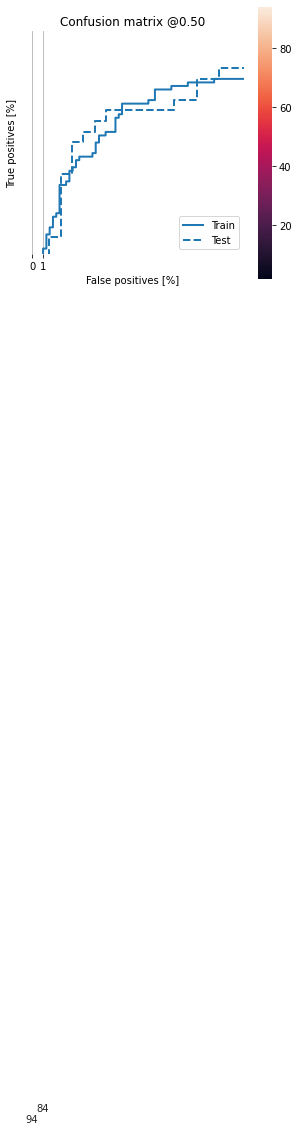

In [22]:
%%time
expId = 106
desc = str(expId) + " IQPEmbedding StronglyEntanglingLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, {"weights": (n_layers, n_qubits, 3)}, output_dim=n_qubits)

model_106, history_106 = runTheExperiments(expId, desc)

# Save Data For Comparisons

In [23]:
#np.savetxt(results_folder + "n" + str(num_data) + "_train_labels.csv", train_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_val_labels.csv", val_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_test_labels.csv", test_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_train_features.csv", train_features, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_val_features.csv", val_features, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_test_features.csv", test_features, delimiter=",")


# Experiments B - Classical Deep Learning

In [24]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          2, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  model.summary()

  return model
  
 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2)                 10        
_________________________________________________________________
dropout_5 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
13/13 [==============================] - 2s 54ms/step - loss: 0.7219 - tp: 137.5000 - fp: 15.0714 - tn: 271.4286 - fn: 144.8571 - accuracy: 0.7330 - precision: 0.9047 - recall: 0.5155 - auc: 0.7365 - val_loss: 0.6798 - val_tp: 34.0000 - val_fp: 11.0000 - val_tn: 62.0000 - val_fn: 52.0000 - val_accuracy: 0.6038 - val_precision: 0.7556 - val_recall: 0.3953 - val_auc: 0.5277

13/13 [==============================] - 0s 6ms/step - loss: 0.6285 - tp: 62.1429 - fp: 11.3571 - tn: 178.4286 - fn: 117.9286 - accuracy: 0.6543 - precision: 0.8502 - recall: 0.3342 - auc: 0.6193 - val_loss: 0.5557 - val_tp: 56.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 30.0000 - val_accuracy: 0.7610 - val_precision: 0.8750 - val_recall: 0.6512 - val_auc: 0.8202
Epoch 21/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.6123 - tp: 70.5000 - fp: 9.0000 - tn: 179.2143 - fn: 111.1429 - accuracy: 0.6852 - precision: 0.9026 - recall: 0.4016 - auc: 0.6502 - val_loss: 0.5526 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 30.0000 - val_accuracy: 0.7673 - val_precision: 0.8889 - val_recall: 0.6512 - val_auc: 0.8214
Epoch 22/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.6104 - tp: 71.4286 - fp: 11.5000 - tn: 176.0714 - fn: 110.8571 - accuracy: 0.6622 - precision: 0.8699 - recall: 0.3830 - auc: 0.6580 - val_loss: 0.5500 - val_tp: 56

13/13 [==============================] - 0s 6ms/step - loss: 0.6091 - tp: 59.0714 - fp: 10.9286 - tn: 179.7857 - fn: 120.0714 - accuracy: 0.6333 - precision: 0.8598 - recall: 0.3159 - auc: 0.6379 - val_loss: 0.5134 - val_tp: 59.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 27.0000 - val_accuracy: 0.7925 - val_precision: 0.9077 - val_recall: 0.6860 - val_auc: 0.8596
Epoch 42/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.5634 - tp: 71.0000 - fp: 8.7143 - tn: 188.8571 - fn: 101.2857 - accuracy: 0.7145 - precision: 0.8999 - recall: 0.4204 - auc: 0.7201 - val_loss: 0.5120 - val_tp: 59.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 27.0000 - val_accuracy: 0.7987 - val_precision: 0.9219 - val_recall: 0.6860 - val_auc: 0.8587
Epoch 43/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.5910 - tp: 65.7857 - fp: 10.2857 - tn: 181.5000 - fn: 112.2857 - accuracy: 0.6634 - precision: 0.8666 - recall: 0.3504 - auc: 0.6852 - val_loss: 0.5110 - val_tp: 59

13/13 [==============================] - 0s 6ms/step - loss: 0.5836 - tp: 68.2857 - fp: 8.4286 - tn: 180.7143 - fn: 112.4286 - accuracy: 0.6723 - precision: 0.8888 - recall: 0.3720 - auc: 0.6929 - val_loss: 0.4968 - val_tp: 57.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 29.0000 - val_accuracy: 0.7862 - val_precision: 0.9194 - val_recall: 0.6628 - val_auc: 0.8676
Epoch 63/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.6028 - tp: 63.4286 - fp: 13.6429 - tn: 180.8571 - fn: 111.9286 - accuracy: 0.6584 - precision: 0.7919 - recall: 0.3628 - auc: 0.6757 - val_loss: 0.4963 - val_tp: 57.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 29.0000 - val_accuracy: 0.7862 - val_precision: 0.9194 - val_recall: 0.6628 - val_auc: 0.8690
Epoch 64/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.5579 - tp: 74.5000 - fp: 11.3571 - tn: 180.2857 - fn: 103.7143 - accuracy: 0.6857 - precision: 0.8761 - recall: 0.4121 - auc: 0.7283 - val_loss: 0.4953 - val_tp: 57

13/13 [==============================] - 0s 6ms/step - loss: 0.5726 - tp: 72.7857 - fp: 12.3571 - tn: 174.9286 - fn: 109.7857 - accuracy: 0.6662 - precision: 0.8706 - recall: 0.3806 - auc: 0.7171 - val_loss: 0.4787 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 28.0000 - val_accuracy: 0.7925 - val_precision: 0.9206 - val_recall: 0.6744 - val_auc: 0.8773
Epoch 84/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.5872 - tp: 65.1429 - fp: 10.6429 - tn: 182.3571 - fn: 111.7143 - accuracy: 0.6591 - precision: 0.8619 - recall: 0.3479 - auc: 0.6884 - val_loss: 0.4780 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 28.0000 - val_accuracy: 0.7925 - val_precision: 0.9206 - val_recall: 0.6744 - val_auc: 0.8810
Epoch 85/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.5342 - tp: 78.1429 - fp: 7.3571 - tn: 186.2857 - fn: 98.0714 - accuracy: 0.7250 - precision: 0.9222 - recall: 0.4546 - auc: 0.7475 - val_loss: 0.4773 - val_tp: 57.

13/13 [==============================] - 0s 6ms/step - loss: 0.5363 - tp: 67.5000 - fp: 5.4286 - tn: 189.4286 - fn: 107.5000 - accuracy: 0.6901 - precision: 0.9313 - recall: 0.3795 - auc: 0.7499 - val_loss: 0.4481 - val_tp: 60.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 26.0000 - val_accuracy: 0.8050 - val_precision: 0.9231 - val_recall: 0.6977 - val_auc: 0.9122
Epoch 105/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.5187 - tp: 66.1429 - fp: 6.1429 - tn: 189.4286 - fn: 108.1429 - accuracy: 0.6998 - precision: 0.9219 - recall: 0.3771 - auc: 0.7719 - val_loss: 0.4459 - val_tp: 61.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 25.0000 - val_accuracy: 0.8113 - val_precision: 0.9242 - val_recall: 0.7093 - val_auc: 0.9103
Epoch 106/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.5369 - tp: 74.8571 - fp: 11.6429 - tn: 176.2143 - fn: 107.1429 - accuracy: 0.6758 - precision: 0.8678 - recall: 0.4182 - auc: 0.7580 - val_loss: 0.4449 - val_tp: 6

13/13 [==============================] - 0s 6ms/step - loss: 0.5248 - tp: 70.2143 - fp: 8.9286 - tn: 185.2143 - fn: 105.5000 - accuracy: 0.6852 - precision: 0.8623 - recall: 0.3935 - auc: 0.7712 - val_loss: 0.4194 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9307
Epoch 126/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.5285 - tp: 66.3571 - fp: 10.2143 - tn: 183.8571 - fn: 109.4286 - accuracy: 0.6723 - precision: 0.8554 - recall: 0.3661 - auc: 0.7713 - val_loss: 0.4180 - val_tp: 62.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 24.0000 - val_accuracy: 0.8239 - val_precision: 0.9394 - val_recall: 0.7209 - val_auc: 0.9314
Epoch 127/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.5239 - tp: 70.8571 - fp: 6.1429 - tn: 180.5714 - fn: 112.2857 - accuracy: 0.6821 - precision: 0.9373 - recall: 0.3987 - auc: 0.7832 - val_loss: 0.4160 - val_tp: 6

13/13 [==============================] - 0s 6ms/step - loss: 0.4946 - tp: 69.8571 - fp: 7.0000 - tn: 180.8571 - fn: 112.1429 - accuracy: 0.6851 - precision: 0.9167 - recall: 0.3964 - auc: 0.7929 - val_loss: 0.3983 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9422
Epoch 147/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4720 - tp: 85.6429 - fp: 7.2857 - tn: 179.0000 - fn: 97.9286 - accuracy: 0.7163 - precision: 0.9283 - recall: 0.4717 - auc: 0.8224 - val_loss: 0.3976 - val_tp: 66.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 20.0000 - val_accuracy: 0.8553 - val_precision: 0.9565 - val_recall: 0.7674 - val_auc: 0.9423
Epoch 148/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.5006 - tp: 71.0714 - fp: 10.1429 - tn: 181.5000 - fn: 107.1429 - accuracy: 0.6886 - precision: 0.8726 - recall: 0.4152 - auc: 0.8039 - val_loss: 0.3971 - val_tp: 65

13/13 [==============================] - 0s 7ms/step - loss: 0.4994 - tp: 69.9286 - fp: 10.2143 - tn: 181.9286 - fn: 107.7857 - accuracy: 0.6837 - precision: 0.8612 - recall: 0.3964 - auc: 0.7840 - val_loss: 0.3848 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9482
Epoch 168/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4655 - tp: 87.7857 - fp: 5.8571 - tn: 178.3571 - fn: 97.8571 - accuracy: 0.7119 - precision: 0.9442 - recall: 0.4776 - auc: 0.8301 - val_loss: 0.3837 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9483
Epoch 169/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4843 - tp: 73.9286 - fp: 6.2143 - tn: 184.7857 - fn: 104.9286 - accuracy: 0.6951 - precision: 0.9247 - recall: 0.4104 - auc: 0.8039 - val_loss: 0.3836 - val_tp: 65

13/13 [==============================] - 0s 6ms/step - loss: 0.4686 - tp: 72.4286 - fp: 4.7143 - tn: 187.5000 - fn: 105.2143 - accuracy: 0.7052 - precision: 0.9441 - recall: 0.4022 - auc: 0.8186 - val_loss: 0.3790 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9526
Epoch 189/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4916 - tp: 75.8571 - fp: 10.5000 - tn: 180.1429 - fn: 103.3571 - accuracy: 0.6953 - precision: 0.8758 - recall: 0.4334 - auc: 0.7996 - val_loss: 0.3786 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9532
Epoch 190/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4781 - tp: 63.5000 - fp: 7.5000 - tn: 189.6429 - fn: 109.2143 - accuracy: 0.6857 - precision: 0.8891 - recall: 0.3690 - auc: 0.8131 - val_loss: 0.3780 - val_tp: 6

13/13 [==============================] - 0s 6ms/step - loss: 0.4750 - tp: 74.6429 - fp: 6.5714 - tn: 180.7857 - fn: 107.8571 - accuracy: 0.6928 - precision: 0.9176 - recall: 0.4169 - auc: 0.8115 - val_loss: 0.3676 - val_tp: 68.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 18.0000 - val_accuracy: 0.8679 - val_precision: 0.9577 - val_recall: 0.7907 - val_auc: 0.9548
Epoch 210/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4876 - tp: 70.2857 - fp: 7.0000 - tn: 185.7143 - fn: 106.8571 - accuracy: 0.6914 - precision: 0.9089 - recall: 0.3837 - auc: 0.7934 - val_loss: 0.3673 - val_tp: 68.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 18.0000 - val_accuracy: 0.8679 - val_precision: 0.9577 - val_recall: 0.7907 - val_auc: 0.9541
Epoch 211/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.5002 - tp: 58.2143 - fp: 4.2143 - tn: 186.9286 - fn: 120.5000 - accuracy: 0.6588 - precision: 0.9385 - recall: 0.3151 - auc: 0.7805 - val_loss: 0.3664 - val_tp: 68

13/13 [==============================] - 0s 7ms/step - loss: 0.4552 - tp: 82.9286 - fp: 8.0000 - tn: 181.7857 - fn: 97.1429 - accuracy: 0.7134 - precision: 0.9028 - recall: 0.4610 - auc: 0.8272 - val_loss: 0.3600 - val_tp: 69.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 17.0000 - val_accuracy: 0.8742 - val_precision: 0.9583 - val_recall: 0.8023 - val_auc: 0.9568
Epoch 231/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4497 - tp: 81.0000 - fp: 6.5000 - tn: 176.8571 - fn: 105.5000 - accuracy: 0.6943 - precision: 0.9288 - recall: 0.4522 - auc: 0.8279 - val_loss: 0.3591 - val_tp: 69.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 17.0000 - val_accuracy: 0.8742 - val_precision: 0.9583 - val_recall: 0.8023 - val_auc: 0.9568
Epoch 232/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4763 - tp: 70.2143 - fp: 7.2143 - tn: 190.0000 - fn: 102.4286 - accuracy: 0.7101 - precision: 0.9198 - recall: 0.4144 - auc: 0.8093 - val_loss: 0.3577 - val_tp: 69.

13/13 [==============================] - 0s 6ms/step - loss: 0.4554 - tp: 82.6429 - fp: 5.4286 - tn: 183.5714 - fn: 98.2143 - accuracy: 0.7192 - precision: 0.9416 - recall: 0.4634 - auc: 0.8269 - val_loss: 0.3507 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9530
Epoch 252/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4639 - tp: 73.4286 - fp: 8.0714 - tn: 188.2857 - fn: 100.0714 - accuracy: 0.7144 - precision: 0.8893 - recall: 0.4311 - auc: 0.8182 - val_loss: 0.3504 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9529
Epoch 253/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4620 - tp: 72.5714 - fp: 5.9286 - tn: 187.8571 - fn: 103.5000 - accuracy: 0.7111 - precision: 0.9255 - recall: 0.4182 - auc: 0.8165 - val_loss: 0.3504 - val_tp: 73.

13/13 [==============================] - 0s 6ms/step - loss: 0.4771 - tp: 82.6429 - fp: 7.4286 - tn: 182.1429 - fn: 97.6429 - accuracy: 0.7091 - precision: 0.9176 - recall: 0.4443 - auc: 0.8156 - val_loss: 0.3440 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9529
Epoch 273/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4725 - tp: 66.2857 - fp: 6.8571 - tn: 189.6429 - fn: 107.0714 - accuracy: 0.6931 - precision: 0.9324 - recall: 0.3728 - auc: 0.8091 - val_loss: 0.3440 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9534
Epoch 274/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4407 - tp: 82.9286 - fp: 6.0000 - tn: 192.7143 - fn: 88.2143 - accuracy: 0.7600 - precision: 0.9203 - recall: 0.4972 - auc: 0.8366 - val_loss: 0.3439 - val_tp: 74.0

13/13 [==============================] - 0s 7ms/step - loss: 0.4734 - tp: 72.0714 - fp: 7.3571 - tn: 185.3571 - fn: 105.0714 - accuracy: 0.6989 - precision: 0.8953 - recall: 0.4087 - auc: 0.7985 - val_loss: 0.3422 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9535
Epoch 294/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4813 - tp: 66.0714 - fp: 6.6429 - tn: 186.9286 - fn: 110.2143 - accuracy: 0.6750 - precision: 0.9248 - recall: 0.3662 - auc: 0.7944 - val_loss: 0.3424 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9536
Epoch 295/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4533 - tp: 82.2857 - fp: 6.5714 - tn: 182.5714 - fn: 98.4286 - accuracy: 0.7241 - precision: 0.9298 - recall: 0.4674 - auc: 0.8258 - val_loss: 0.3421 - val_tp: 74.

13/13 [==============================] - 0s 6ms/step - loss: 0.4348 - tp: 77.8571 - fp: 5.2857 - tn: 191.4286 - fn: 95.2857 - accuracy: 0.7360 - precision: 0.9454 - recall: 0.4551 - auc: 0.8469 - val_loss: 0.3363 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9560
Epoch 315/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4428 - tp: 76.8571 - fp: 5.9286 - tn: 187.5000 - fn: 99.5714 - accuracy: 0.7265 - precision: 0.9419 - recall: 0.4517 - auc: 0.8384 - val_loss: 0.3358 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9564
Epoch 316/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4632 - tp: 81.9286 - fp: 5.2857 - tn: 185.1429 - fn: 97.5000 - accuracy: 0.7108 - precision: 0.9416 - recall: 0.4441 - auc: 0.8231 - val_loss: 0.3357 - val_tp: 74.00

13/13 [==============================] - 0s 6ms/step - loss: 0.4607 - tp: 85.1429 - fp: 9.7143 - tn: 177.6429 - fn: 97.3571 - accuracy: 0.7120 - precision: 0.8818 - recall: 0.4705 - auc: 0.8114 - val_loss: 0.3296 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9556
Epoch 336/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4805 - tp: 79.0714 - fp: 6.2143 - tn: 182.6429 - fn: 101.9286 - accuracy: 0.7102 - precision: 0.9338 - recall: 0.4484 - auc: 0.8050 - val_loss: 0.3302 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9552
Epoch 337/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4600 - tp: 76.8571 - fp: 6.1429 - tn: 193.7857 - fn: 93.0714 - accuracy: 0.7271 - precision: 0.9071 - recall: 0.4415 - auc: 0.8155 - val_loss: 0.3296 - val_tp: 74.0

13/13 [==============================] - 0s 6ms/step - loss: 0.4648 - tp: 66.4286 - fp: 7.6429 - tn: 192.4286 - fn: 103.3571 - accuracy: 0.7106 - precision: 0.8870 - recall: 0.3799 - auc: 0.8083 - val_loss: 0.3313 - val_tp: 75.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 11.0000 - val_accuracy: 0.9119 - val_precision: 0.9615 - val_recall: 0.8721 - val_auc: 0.9553
Epoch 357/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4500 - tp: 74.7857 - fp: 4.6429 - tn: 191.2143 - fn: 99.2143 - accuracy: 0.7193 - precision: 0.9545 - recall: 0.4220 - auc: 0.8296 - val_loss: 0.3294 - val_tp: 75.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 11.0000 - val_accuracy: 0.9119 - val_precision: 0.9615 - val_recall: 0.8721 - val_auc: 0.9545
Epoch 358/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4764 - tp: 80.7143 - fp: 3.0714 - tn: 188.0000 - fn: 98.0714 - accuracy: 0.7198 - precision: 0.9528 - recall: 0.4403 - auc: 0.8034 - val_loss: 0.3284 - val_tp: 75.0

13/13 [==============================] - 0s 6ms/step - loss: 0.4418 - tp: 78.9286 - fp: 5.7857 - tn: 194.1429 - fn: 91.0000 - accuracy: 0.7465 - precision: 0.9343 - recall: 0.4646 - auc: 0.8287 - val_loss: 0.3259 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Epoch 378/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4340 - tp: 83.1429 - fp: 8.7143 - tn: 185.9286 - fn: 92.0714 - accuracy: 0.7351 - precision: 0.9077 - recall: 0.4867 - auc: 0.8430 - val_loss: 0.3259 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9542
Epoch 379/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4420 - tp: 77.7857 - fp: 4.7143 - tn: 187.4286 - fn: 99.9286 - accuracy: 0.7183 - precision: 0.9529 - recall: 0.4412 - auc: 0.8356 - val_loss: 0.3257 - val_tp: 75.00

13/13 [==============================] - 0s 6ms/step - loss: 0.4954 - tp: 74.0000 - fp: 6.5714 - tn: 182.1429 - fn: 107.1429 - accuracy: 0.6870 - precision: 0.9211 - recall: 0.3954 - auc: 0.7932 - val_loss: 0.3263 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9540
Epoch 399/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4880 - tp: 83.1429 - fp: 5.3571 - tn: 182.6429 - fn: 98.7143 - accuracy: 0.7101 - precision: 0.9335 - recall: 0.4624 - auc: 0.7927 - val_loss: 0.3267 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Epoch 400/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4478 - tp: 82.6429 - fp: 5.0714 - tn: 185.1429 - fn: 97.0000 - accuracy: 0.7124 - precision: 0.9433 - recall: 0.4515 - auc: 0.8407 - val_loss: 0.3253 - val_tp: 75.0

13/13 [==============================] - 0s 6ms/step - loss: 0.4512 - tp: 79.8571 - fp: 5.2857 - tn: 187.7143 - fn: 97.0000 - accuracy: 0.7160 - precision: 0.9286 - recall: 0.4512 - auc: 0.8264 - val_loss: 0.3215 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Restoring model weights from the end of the best epoch.
Epoch 00419: early stopping
loss :  0.28389766812324524
tp :  95.0
fp :  4.0
tn :  92.0
fn :  8.0
accuracy :  0.9396985173225403
precision :  0.9595959782600403
recall :  0.9223300814628601
auc :  0.978762149810791

Legitimate Domain Name Detected (True Negatives):  92
Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives):  4
Botnet DGA Missed (False Negatives):  8
Botnet DGA Detected (True Positives):  95
Total Botnet DGAs:  103
CPU times: user 58.7 s, sys: 4.54 s, total: 1min 3s
Wall time: 48.3 s


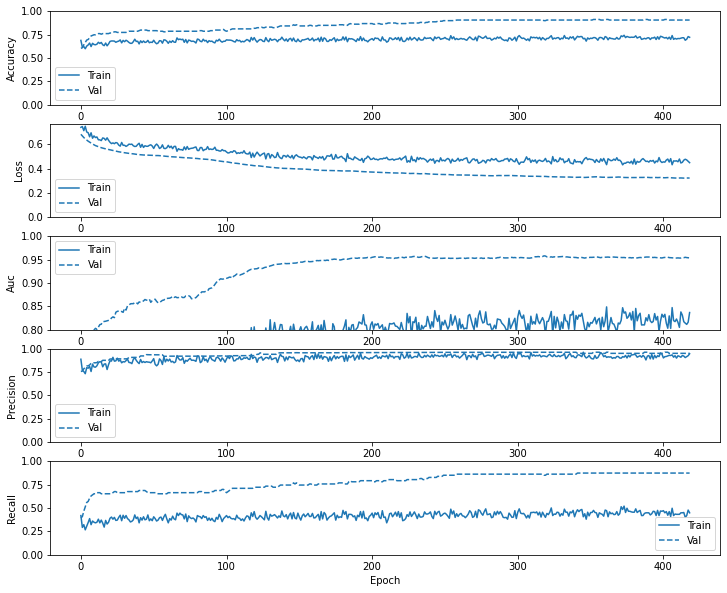

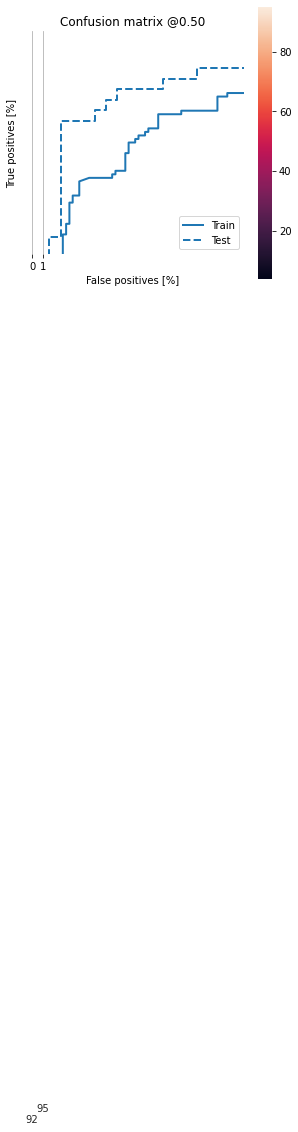

In [25]:
%%time
expId = 201
desc = str(expId) + " Classical Deep Learning" 

model_201, history_201 = runTheExperiments(expId, desc)


In [26]:
f.write("19_BotnetDga_Benchmarks - CPU n100 1layer - Device Noise Model ibmq_16_melbourne - qiskit.aer - seed 123")
f.flush()